In [ ]:
import numpy as np
import math
import matplotlib.pyplot as plt

In [ ]:
# Set some properties of the model. We'll store these in a dict so they're
# easier to pass around or save.
model = {}

# properties of the recurrent pool:
model['N'] = 3  # number of neurons
model['g'] = 0.9  # gain of synaptic weights in pool
model['sp'] = 0.33  # fraction of weights that are nonzero
model['tau'] = 20  # neural membrane time constant in ms
model['dt'] = 0.1  # simulation timestep in ms
model['nonlin'] = lambda x: np.tanh(x)  # firing rate nonlinearity for pool units

# properties of the input layer:
# a note: we're going to encode the "value" of the input by the identity of the
# active input layer units. We'll use one-hot encoding: for each input step
# during simulation, one unit will be activated with "firing rate" 1, and the
# rest will be set to firing rate 0 (adjust gIn to change the scaling of input
# to the recurrent pool.)
# Note 1: This is just one way of setting up input- are there other approaches
# that would improve memory capacity?
# Note 2: Burn-in time is especially important if your model has g>1, in which
# case neurons will be spontaneously active.
model['nIn'] = 2  # size of the input layer
model['gIn'] = 10.0  # gain of the input weights
model['spIn'] = 0.0  # sparsity of input->pool connectivity
model['burnIn'] = 0  # time before input starts
model['durIn'] = 1  # time for which an input is active in ms
model['ISI'] = 0  # time between inputs in ms
model['nonlinIn'] = lambda x: x  # best to keep the input linear

In [ ]:
# Create the synaptic weight matrix.
# Normalizing weights by sqrt(N*sparsity) keeps the eigenvalue spectrum
# invariant to the size of the population N.
randMat  = np.random.normal(0, 1, size=(model['N'], model['N']))
spMat  = np.random.uniform(0, 1, size=(model['N'], model['N'])) <= model['sp']
model['J'] = np.multiply(randMat, spMat) * model['g'] / math.sqrt(model['N'] * model['sp'])

# Create the input weight matrix.
randMatIn = np.random.normal(0, 1, size=(model['N'], model['nIn']))
spMatIn = np.random.uniform(0, 1, size=(model['N'], model['nIn'])) <= model['spIn']
model['Jin'] = np.multiply(randMatIn, spMatIn) * model['gIn'] / math.sqrt(model['nIn'] * model['spIn'])

/tmp/ipython-input-11-2493390624.py:11: RuntimeWarning: invalid value encountered in divide
  model['Jin'] = np.multiply(randMatIn, spMatIn) * model['gIn'] / math.sqrt(model['nIn'] * model['spIn'])


In [ ]:
# Define a couple helper functions for simulation.

def step(firing_rates, input_layer, model):
  # The simulation function. We use Euler's method to simulate the evolution of
  # model neuron firing rates given the input_layer firing rates.

  timestep = math.exp(-model['dt']/model['tau'])
  vIn = np.matmul(model['J'], firing_rates) \
        + np.matmul(model['Jin'], model['nonlinIn'](input_layer))
  updated_rates = model['nonlin'](vIn + (firing_rates - vIn) * timestep)

  return updated_rates


def make_input(sequence_length, model):
  # Generates a sequence of inputs according to the parameters in model. Returns
  # the sequence both as a one-hot encoding and as a sequence of integer values.

  input_stream = [0] * int(model['burnIn']/model['dt'])

  for i in range(sequence_length):
    val = np.random.randint(0, model['nIn']) + 1
    for t in range(int(model['ISI']/model['dt'])):
      input_stream.append(0.0)
    for t in range(int(model['durIn']/model['dt'])):
      input_stream.append(val)

  input_stream = np.array(input_stream)

  onehot = np.zeros((model['nIn'] + 1, input_stream.size))
  onehot[input_stream, np.arange(input_stream.size)] = 1.0
  onehot = onehot[1:, :]

  return onehot, input_stream

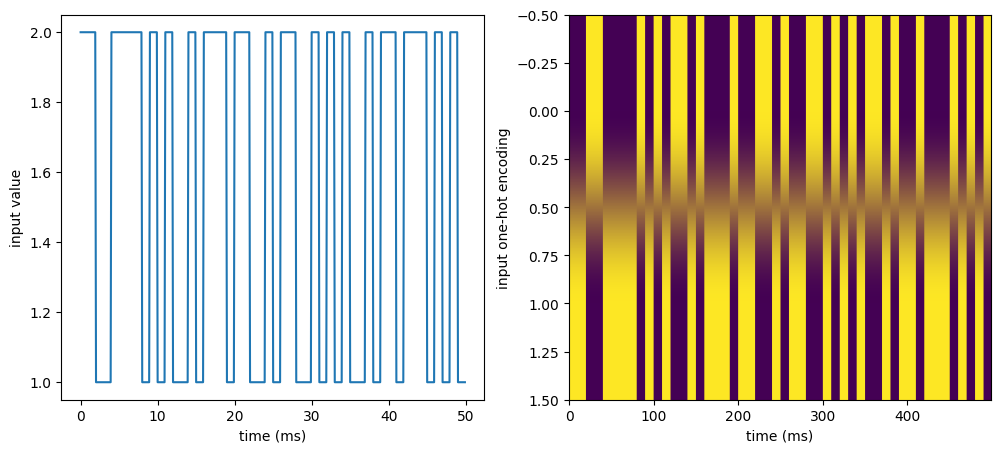

In [ ]:
# Look at an example input stream.

onehot, stream = make_input(50, model)

fig, ax = plt.subplots(1, 2, figsize=(12, 5))
omit = int(model['burnIn']/model['dt']) # don't plot the burn-in period
ax[0].plot(np.arange(len(stream) - omit) * model['dt'], stream[omit:])
ax[0].set_xlabel('time (ms)')
ax[0].set_ylabel('input value')

ax[1].imshow(onehot[:, omit:], aspect='auto')
ax[1].set_xlabel('time (ms)')
ax[1].set_ylabel('input one-hot encoding')
fig.show()

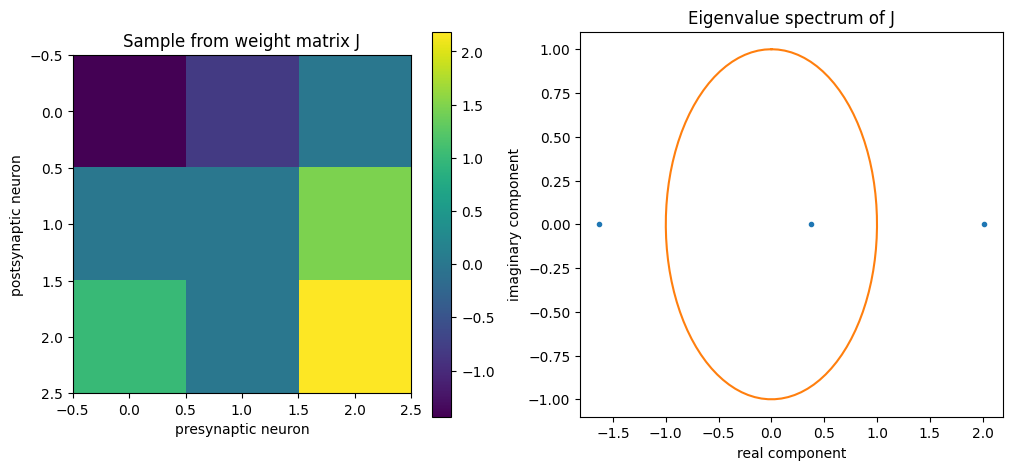

In [ ]:
# Take a look at the eigenvalue spectrum of J.
w, v = np.linalg.eig(model['J'])

fig, ax = plt.subplots(1, 2, figsize=(12, 5))
showCount = 50  # portion of J to actually show (for readability)
h = ax[0].imshow(model['J'][:showCount,:showCount])
ax[0].set_title('Sample from weight matrix J')
ax[0].set_xlabel('presynaptic neuron')
ax[0].set_ylabel('postsynaptic neuron')
plt.colorbar(h, ax=ax[0])

ax[1].plot(np.real(w),np.imag(w),'.')
ax[1].plot(np.sin(np.linspace(0,2*math.pi,100)),
           np.cos(np.linspace(0,2*math.pi,100)))  # circle with radius 1
ax[1].set_title('Eigenvalue spectrum of J')
ax[1].set_xlabel('real component')
ax[1].set_ylabel('imaginary component')
fig.show()

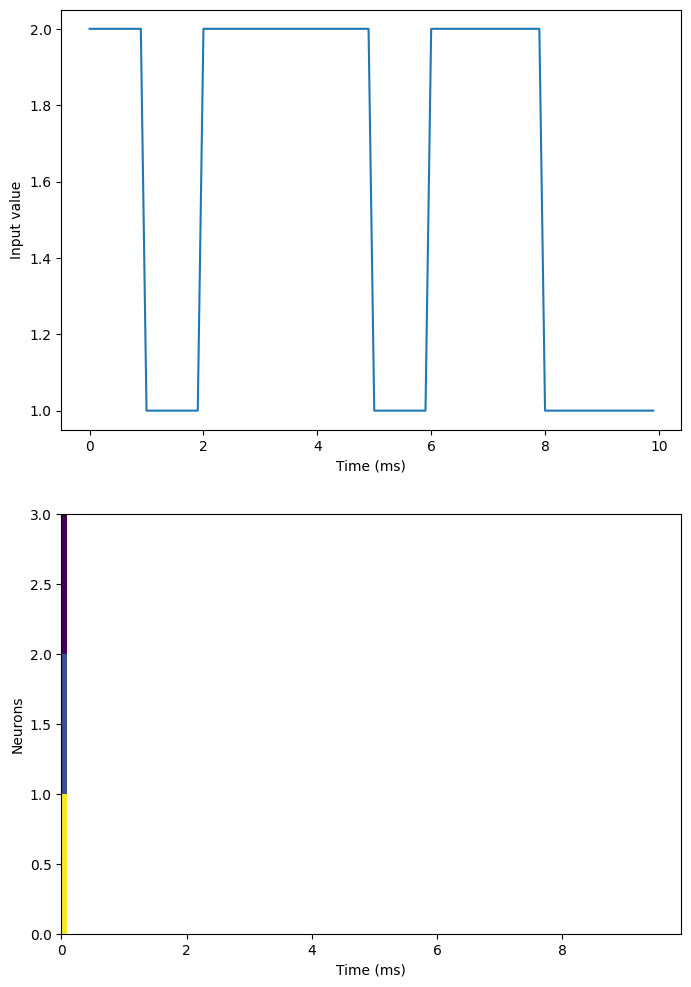

In [ ]:
# Simulate the model activity.

# generate the input to the model
onehot, input_stream = make_input(10, model)

# initialize the firing rates randomly
firing_rates = np.zeros((model['N'], len(input_stream)))
firing_rates[:, 0] = np.random.uniform(0, 0.1, size=(model['N']))

for t in range(len(input_stream)-1):
  firing_rates[:,t+1] = step(firing_rates[:,t], onehot[:,t], model)


fig, ax = plt.subplots(2, 1, figsize=(8, 12))
simulation_time = np.arange(len(input_stream))*model['dt'] - model['burnIn']
ax[0].plot(simulation_time, input_stream)
ax[0].set_xlabel('Time (ms)')
ax[0].set_ylabel('Input value')

extents = [simulation_time[0],simulation_time[-1], 0, model['N']]
ax[1].imshow(firing_rates, aspect='auto', extent=extents)
ax[1].set_xlabel('Time (ms)')
ax[1].set_ylabel('Neurons')
fig.show()

Now: can you decode the model's input history from its firing rates?

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import fsolve

Monotonic Transfer Functions (+ tanh)

In [ ]:
def sigmoid(x):
  return 1 / (1 + np.exp(-x))

In [ ]:
def relu(x):
  return np.maximum(0, x)

In [ ]:
def leak_relu(x, a=0.01):
  return np.maximum(a*x, x)

In [ ]:
def softplus(x):
  return np.log(1 + np.exp(x))

In [ ]:
# 1. SETUP: Define model parameters
# ==================================
N = 3  # Number of neurons (2 excitatory, 1 inhibitory)
tau = 20.0  # Membrane time constant in ms
dt = 0.1  # Simulation timestep in ms
T = 1000.0  # Total simulation time in ms
timesteps = np.arange(0, T, dt)

# Transfer function (sigmoidal nonlinearity)
def transfer_function(x):
    return np.tanh(x)

In [ ]:
# 2. CONNECTIVITY: Define the synaptic weight matrix J
# ==================================================
# J[i, j] is the weight from neuron j to neuron i

# Let's define a simple "winner-take-all" like structure
# Neuron 0: Excitatory 1
# Neuron 1: Excitatory 2
# Neuron 2: Inhibitory

J = np.array([
    [1.2, -0.5, -1.0],  # Inputs to Neuron 0 (E1) from E1, E2, I
    [-0.5, 1.5, -1.0],  # Inputs to Neuron 1 (E2) from E1, E2, I
    [1.0, 1.0, 0.0]   # Inputs to Neuron 2 (I) from E1, E2, I
])
# Note: The 3rd column represents outputs from the inhibitory neuron,
# which are correctly negative for the E-neurons.

# J = J /

In [ ]:
# 3. SIMULATION SETUP
# ====================
# Initialize firing rates history
rates = np.zeros((N, len(timesteps)))

# Set initial firing rates to small random values
# rates[:, 0] = np.random.rand(N) * 0.1

In [ ]:
# 4. INPUT SETUP
# ================
# Define an external input pulse to the first excitatory neuron
I_ext = np.zeros((N, len(timesteps)))
I_ext[0, 1500:2000] = 1.0  # Apply a pulse of amplitude 1.0 to Neuron 0
                           # from t=100ms to t=200ms
# I_ext[2, 2000:3000] = 1.0

In [ ]:
# 5. SIMULATION LOOP (Euler Method)
# =================================
for t in range(len(timesteps) - 1):
    # Get current rates and input
    r_current = rates[:, t]
    I_current = I_ext[:, t]

    # Calculate total synaptic input
    I_synaptic = J @ r_current

    # The differential equation: tau * dr/dt = -r + F(I_syn + I_ext)
    # Euler method update: r(t+dt) = r(t) + dt/tau * [F(total_input) - r(t)]
    total_input = I_synaptic + I_current
    rates[:, t+1] = r_current + (dt / tau) * (transfer_function(total_input) - r_current)

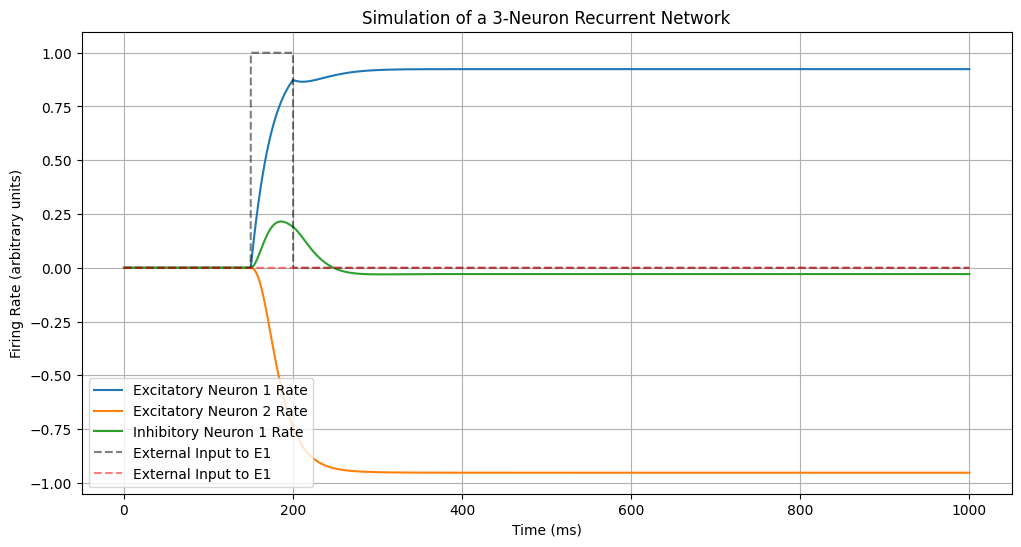

In [ ]:
# 6. PLOTTING
# =============
plt.figure(figsize=(12, 6))
plt.plot(timesteps, rates[0, :], label='Excitatory Neuron 1 Rate')
plt.plot(timesteps, rates[1, :], label='Excitatory Neuron 2 Rate')
plt.plot(timesteps, rates[2, :], label='Inhibitory Neuron 1 Rate')

# Plot the input pulse for reference
plt.plot(timesteps, I_ext[0, :], 'k--', label='External Input to E1', alpha=0.5)
plt.plot(timesteps, I_ext[2, :], 'r--', label='External Input to E1', alpha=0.5)

plt.title('Simulation of a 3-Neuron Recurrent Network')
plt.xlabel('Time (ms)')
plt.ylabel('Firing Rate (arbitrary units)')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
D = np.diag(np.array([.98, 1.41, 1.41]))
rand_mat = np.random.rand(N, N)
Q, _ = np.linalg.qr(rand_mat)
J = Q @ D @ Q.T
J[2][2] = 0.0
J[2][:-1] = [abs(J[2][0]), abs(J[2][1])]
J

array([[ 1.23896803, -0.17470683, -0.11734282],
       [-0.17470683,  1.23153936, -0.11986409],
       [ 0.11734282,  0.11986409,  0.        ]])

In [ ]:
for eig in np.linalg.eigvals(J):
  print(abs(eig))
# np.linalg.eigvals(J)

1.410000000000001
1.0332767984792541
0.027230590772517323


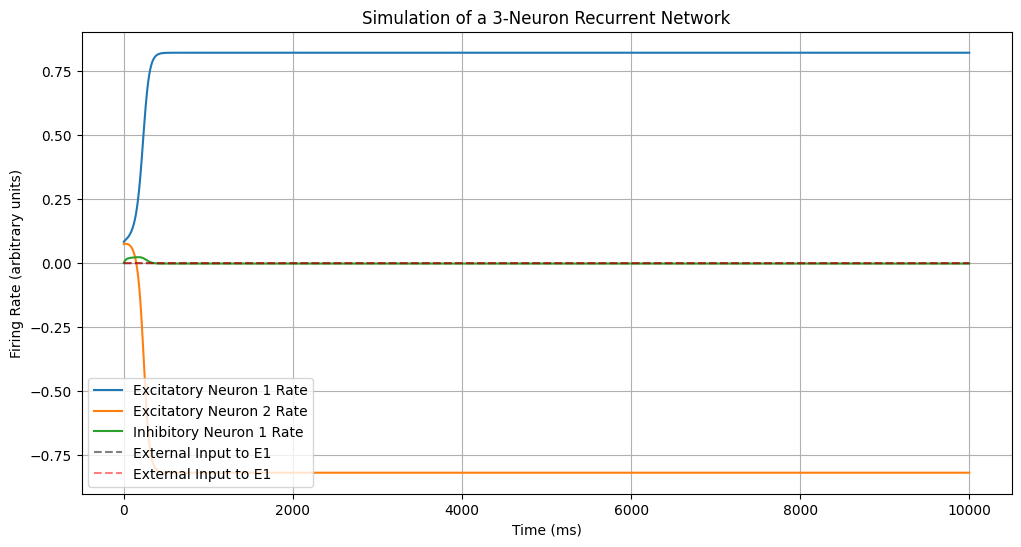

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(timesteps, rates[0, :], label='Excitatory Neuron 1 Rate')
plt.plot(timesteps, rates[1, :], label='Excitatory Neuron 2 Rate')
plt.plot(timesteps, rates[2, :], label='Inhibitory Neuron 1 Rate')

# Plot the input pulse for reference
plt.plot(timesteps, I_ext[0, :], 'k--', label='External Input to E1', alpha=0.5)
plt.plot(timesteps, I_ext[2, :], 'r--', label='External Input to E1', alpha=0.5)

plt.title('Simulation of a 3-Neuron Recurrent Network')
plt.xlabel('Time (ms)')
plt.ylabel('Firing Rate (arbitrary units)')
plt.legend()
plt.grid(True)
plt.show()

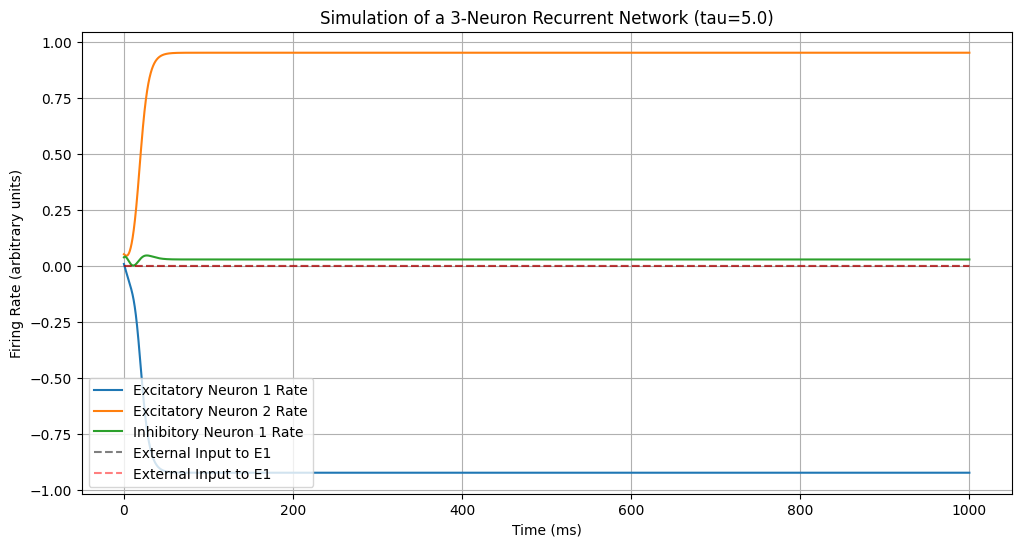

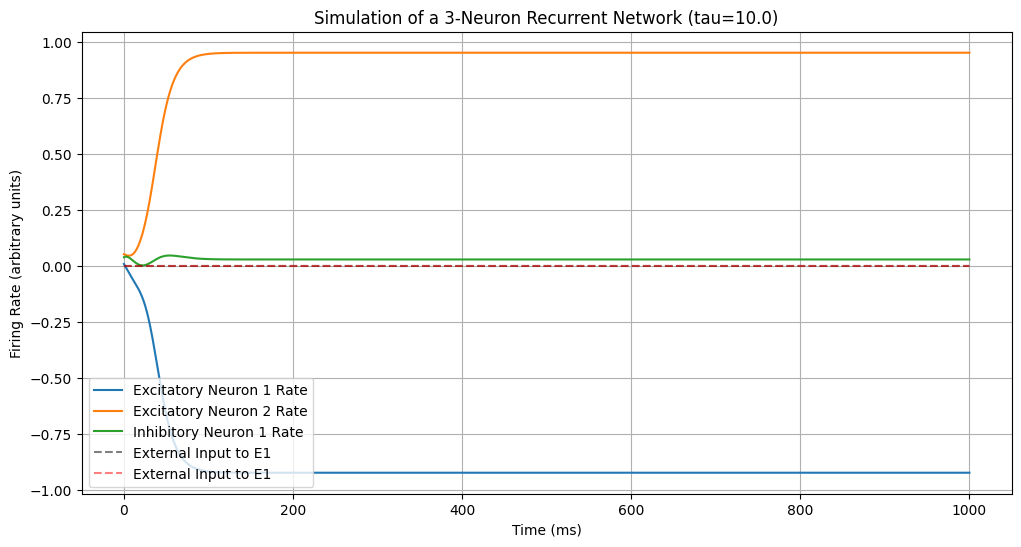

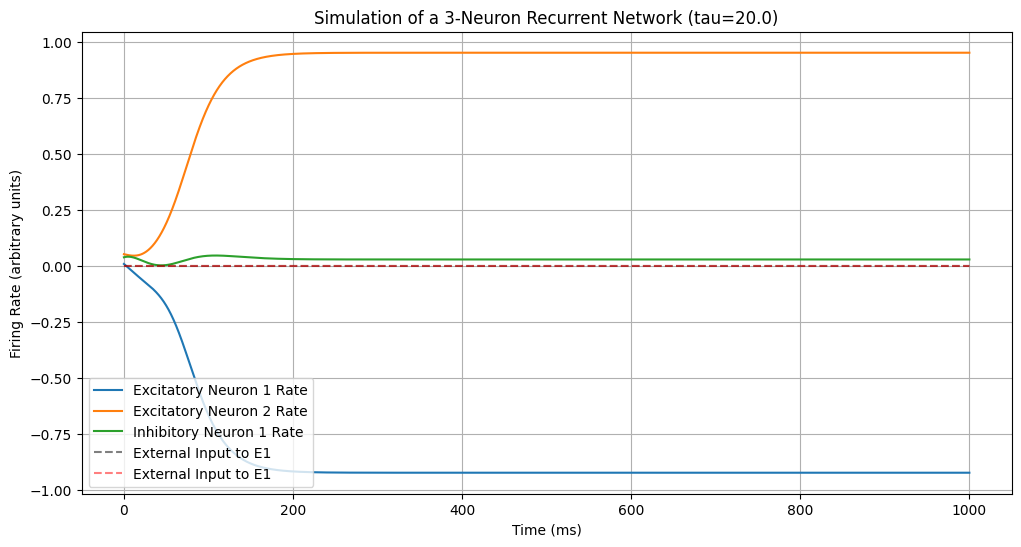

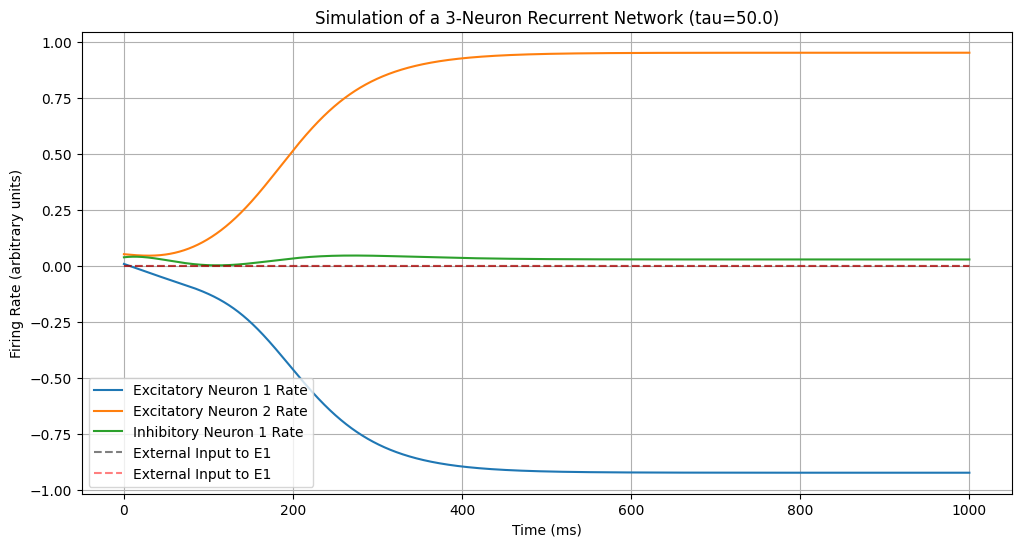

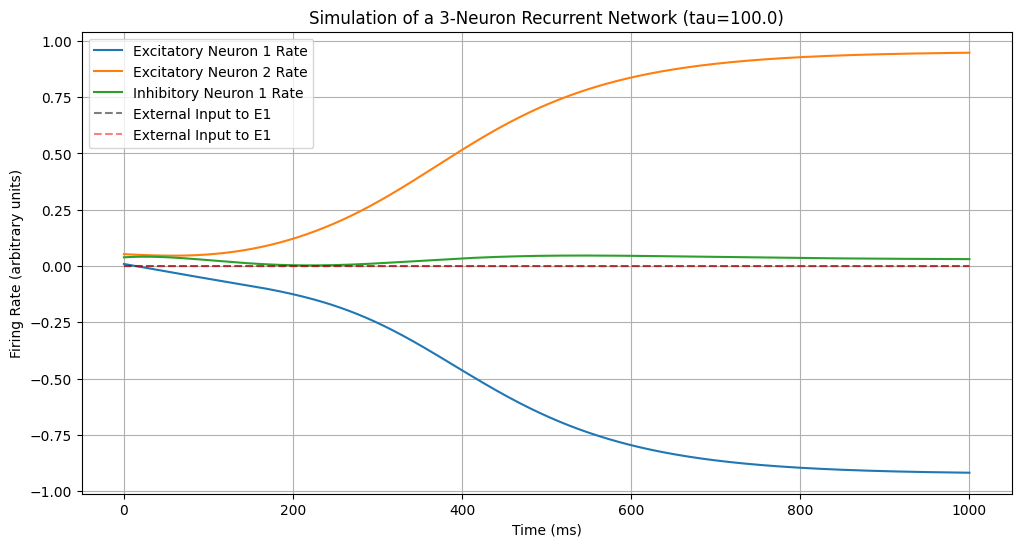

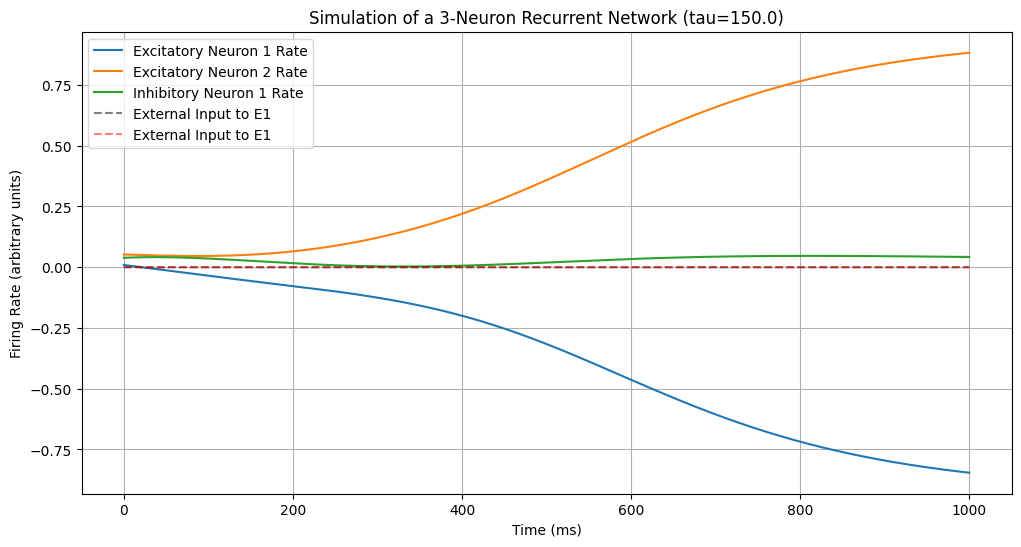

In [ ]:
taus = [5.0, 10.0, 20.0, 50.0, 100.0, 150.0]

for tau in taus:
    for t in range(len(timesteps) - 1):
        # Get current rates and input
        r_current = rates[:, t]
        I_current = I_ext[:, t]

        # Calculate total synaptic input
        I_synaptic = J @ r_current

        # The differential equation: tau * dr/dt = -r + F(I_syn + I_ext)
        # Euler method update: r(t+dt) = r(t) + dt/tau * [F(total_input) - r(t)]
        total_input = I_synaptic + I_current
        rates[:, t+1] = r_current + (dt / tau) * (transfer_function(total_input) - r_current)

    plt.figure(figsize=(12, 6))
    plt.plot(timesteps, rates[0, :], label='Excitatory Neuron 1 Rate')
    plt.plot(timesteps, rates[1, :], label='Excitatory Neuron 2 Rate')
    plt.plot(timesteps, rates[2, :], label='Inhibitory Neuron 1 Rate')

    # Plot the input pulse for reference
    plt.plot(timesteps, I_ext[0, :], 'k--', label='External Input to E1', alpha=0.5)
    plt.plot(timesteps, I_ext[2, :], 'r--', label='External Input to E1', alpha=0.5)

    plt.title(f'Simulation of a 3-Neuron Recurrent Network (tau={tau})')
    plt.xlabel('Time (ms)')
    plt.ylabel('Firing Rate (arbitrary units)')
    plt.legend()
    plt.grid(True)
    plt.show()

In [ ]:
# 2. NULLCLINE CALCULATION
# ========================
# Create a grid of r0 and r1 values to represent the state space
r_range = np.linspace(-2, 2, 100)
r0_grid, r1_grid = np.meshgrid(r_range, r_range)

# Q2 Simplification: The inhibitory rate r2 is an instantaneous function of r0 and r1
r2_grid = transfer_function(J[2, 0] * r0_grid + J[2, 1] * r1_grid)

# Calculate the rate of change (dr/dt) for each excitatory neuron at each point on the grid
# The nullcline is where dr/dt = 0, which from the ODE means -r + F(total_input) = 0
# We calculate this value, and later plot the contour where it equals zero.
dr0dt_grid = -r0_grid + transfer_function(J[0, 0] * r0_grid + J[0, 1] * r1_grid + J[0, 2] * r2_grid)
dr1dt_grid = -r1_grid + transfer_function(J[1, 0] * r0_grid + J[1, 1] * r1_grid + J[1, 2] * r2_grid)

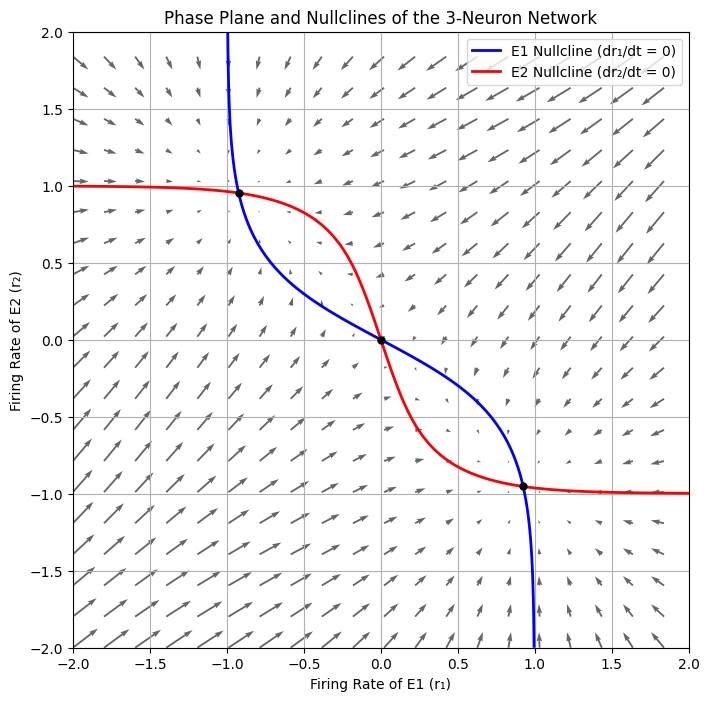

In [ ]:
# 3. PLOTTING THE PHASE PLANE
# ===========================
plt.figure(figsize=(8, 8))

# Plot the E1-nullcline (where dr0/dt = 0)
plt.contour(r0_grid, r1_grid, dr0dt_grid, levels=[0], colors='blue', linewidths=2)

# Plot the E2-nullcline (where dr1/dt = 0)
plt.contour(r0_grid, r1_grid, dr1dt_grid, levels=[0], colors='red', linewidths=2)

# Find and plot the fixed points (intersections of the nullclines)
# For this specific J matrix, there are three intersection points.
# plt.plot([0.05, 0.95, 0.35], [0.95, 0.05, 0.35], 'ko', markersize=8) # Fixed points marked manually

# Add a vector field (quiver plot) to show the flow of the dynamics
# This shows the direction the system will evolve from any point
plt.quiver(r0_grid[::5, ::5], r1_grid[::5, ::5], dr0dt_grid[::5, ::5], dr1dt_grid[::5, ::5], alpha=0.6)

# Create custom legend entries
from matplotlib.lines import Line2D
legend_elements = [Line2D([0], [0], color='blue', lw=2, label='E1 Nullcline (dr₁/dt = 0)'),
                   Line2D([0], [0], color='red', lw=2, label='E2 Nullcline (dr₂/dt = 0)'),
                  #  Line2D([0], [0], marker='o', color='w', label='Fixed Points', markerfacecolor='k', markersize=8)
                  ]

plt.plot(fixed_point_1[0], fixed_point_1[1], 'ko', markersize=5, label='Stable Fixed Point 1')
plt.plot(fixed_point_2[0], fixed_point_2[1], 'ko', markersize=5, label='Stable Fixed Point 2')
plt.plot(fixed_point_3[0], fixed_point_3[1], 'ko', markersize=5, label='Stable Fixed Point 3')
# plt.plot(fixed_point_4[0], fixed_point_4[1], 'ko', markersize=5, label='Stable Fixed Point 4')
# plt.plot(fixed_point_5[0], fixed_point_5[1], 'ko', markersize=5, label='Stable Fixed Point 5')

plt.title('Phase Plane and Nullclines of the 3-Neuron Network')
plt.xlabel('Firing Rate of E1 (r₁)')
plt.ylabel('Firing Rate of E2 (r₂)')
plt.legend(handles=legend_elements)
plt.grid(True)
plt.axis('square')
plt.show()

In [ ]:
def fixed_point_equations(r_vec):
    """Defines the system of equations to be solved."""
    r0, r1 = r_vec[0], r_vec[1]

    # Calculate the instantaneous inhibitory rate
    r2 = transfer_function(J[2, 0] * r0 + J[2, 1] * r1)

    # Error equations: err = r - F(J@r)
    err0 = r0 - transfer_function(J[0, 0] * r0 + J[0, 1] * r1 + J[0, 2] * r2)
    err1 = r1 - transfer_function(J[1, 0] * r0 + J[1, 1] * r1 + J[1, 2] * r2)

    return [err0, err1]

In [ ]:
initial_guess_1 = [-0.8, 0.8]
initial_guess_2 = [0, 0]
initial_guess_3 = [0.8, -0.8]
# initial_guess_4 = [0.25, 0.25]
# initial_guess_5 = [-0.25, -0.25]

fixed_point_1 = fsolve(fixed_point_equations, initial_guess_1)
fixed_point_2 = fsolve(fixed_point_equations, initial_guess_2)
fixed_point_3 = fsolve(fixed_point_equations, initial_guess_3)
# fixed_point_4 = fsolve(fixed_point_equations, initial_guess_4)
# fixed_point_5 = fsolve(fixed_point_equations, initial_guess_5)

print(fixed_point_1)
print(fixed_point_2)
print(fixed_point_3)
# print(fixed_point_4)
# print(fixed_point_5)

[-0.92375609  0.95287044]
[0. 0.]
[ 0.92375609 -0.95287044]


In [ ]:
def tanh_prime(x):
    """Derivative of the tanh transfer function."""
    return 1.0 - np.tanh(x)**2

In [ ]:
def calculate_jacobian(r_vec):
    """Calculates the 2x2 Jacobian matrix at a given fixed point (r0, r1)."""
    r0, r1 = r_vec[0], r_vec[1]

    # Pre-calculate intermediate values at the fixed point
    u_i = J[2, 0] * r0 + J[2, 1] * r1
    r_i = transfer_function(u_i)

    u_e1 = J[0, 0] * r0 + J[0, 1] * r1 + J[0, 2] * r_i
    u_e2 = J[1, 0] * r0 + J[1, 1] * r1 + J[1, 2] * r_i

    # Calculate the four partial derivatives using the chain rule
    # Note: We omit the (1/tau) factor as it just scales the eigenvalues
    # and doesn't change the sign of their real parts.

    # d(dr0/dt) / dr0
    df0_dr0 = -1 + tanh_prime(u_e1) * (J[0, 0] + J[0, 2] * tanh_prime(u_i) * J[2, 0])
    # d(dr0/dt) / dr1
    df0_dr1 = tanh_prime(u_e1) * (J[0, 1] + J[0, 2] * tanh_prime(u_i) * J[2, 1])
    # d(dr1/dt) / dr0
    df1_dr0 = tanh_prime(u_e2) * (J[1, 0] + J[1, 2] * tanh_prime(u_i) * J[2, 0])
    # d(dr1/dt) / dr1
    df1_dr1 = -1 + tanh_prime(u_e2) * (J[1, 1] + J[1, 2] * tanh_prime(u_i) * J[2, 1])

    jacobian_matrix = np.array([[df0_dr0, df0_dr1], [df1_dr0, df1_dr1]])

    return jacobian_matrix

In [ ]:
fp = fixed_point_2

jacobian = calculate_jacobian(fp)

# Calculate the eigenvalues of the Jacobian
eigenvalues = np.linalg.eigvals(jacobian)

print(f"Fixed Point: r = ({fp[0]:.4f}, {fp[1]:.4f})")
print(f"Eigenvalues: {eigenvalues[0]:.4f}, {eigenvalues[1]:.4f}")

Fixed Point: r = (0.0000, 0.0000)
Eigenvalues: -2.1575, 0.8575


# Single Memory

In [ ]:
import numpy as np
import math
import matplotlib.pyplot as plt

In [ ]:
np.random.seed(25)

model = {}

# Network Properties
model['N'] = 30          # Number of neurons
model['g'] = 0.9          # Gain of synaptic weights
model['sp'] = 0.25        # Sparsity
model['tau'] = 50.0       # Membrane time constant (ms)
model['dt'] = 0.1         # Simulation timestep (ms)
model['nonlin'] = lambda x: np.tanh(x)

# Input Properties
model['nIn'] = 5          # Total possible inputs (we'll only use one)
model['gIn'] = 0.7        # Input gain
model['spIn'] = 0.1       # Input sparsity

In [ ]:
# Simulation Parameters
simulation_time = 5000.0
n_timesteps = int(simulation_time / model['dt'])
stimulus_id = 3 # The stimulus to be learned

In [ ]:
# Create the initial random recurrent weight matrix J
randMat = np.random.normal(0, 1, size=(model['N'], model['N']))
spMat = np.random.uniform(0, 1, size=(model['N'], model['N'])) <= model['sp']
J_initial = np.multiply(randMat, spMat) * model['g'] / math.sqrt(model['N'] * model['sp'])

# Create the fixed input weight matrix Jin
spMatIn = np.random.uniform(0, 1, size=(model['N'], model['nIn'])) <= model['spIn']
Jin = spMatIn.astype(float) * 1.0 * model['gIn'] / math.sqrt(model['nIn'] * model['spIn'])

In [ ]:
# Create an input stream with repeated presentations of a single stimulus
input_stream = np.zeros((model['nIn'], n_timesteps))
duration = 50.0
interval = 200.0
current_time = 100.0
while current_time < simulation_time:
    start_idx = int(current_time / model['dt'])
    end_idx = int((current_time + duration) / model['dt'])
    if end_idx >= n_timesteps: break
    input_stream[stimulus_id, start_idx:end_idx] = 1.0
    current_time += interval

In [ ]:
def run_learning_simulation(J0, rule_type='hebbian'):
    J = J0.copy()
    firing_rates = np.zeros((model['N'], n_timesteps))
    firing_rates[:, 0] = np.random.uniform(0, 0.1, size=(model['N']))

    # Parameters for rules
    # if rule_type == 'bcm':
    #     theta = np.zeros(model['N']) # BCM threshold
    #     lr = 0.02
    # elif rule_type == 'stdp':
    #     lr_ltp = 0.01  # Learning rate for potentiation
    #     lr_ltd = 0.012 # Learning rate for depression
    #     tau_trace = 200.0 # Time constant for synaptic traces in ms
    #     pre_trace = np.zeros(model['N'])
    #     post_trace = np.zeros(model['N'])
    # else: # hebbian or anti-hebbian
    lr = 0.005

    print(f"Starting training with {rule_type.upper()} rule...")
    for t in range(n_timesteps - 1):
        r_current = firing_rates[:, t]
        I_synaptic = J @ r_current
        I_input = Jin @ input_stream[:, t]
        total_input = I_synaptic + I_input
        r_new = r_current + (model['dt'] / model['tau']) * (-r_current + model['nonlin'](total_input))
        firing_rates[:, t+1] = np.clip(r_new, -1.0, 1.0)

        if rule_type == 'hebbian':
            update = np.outer(firing_rates[:, t+1], r_current)
            J += lr * update - (lr * 0.1) * J

        elif rule_type == 'anti-hebbian':
            update = np.outer(firing_rates[:, t+1], r_current)
            J -= lr * update - (lr * 0.1) * J

        # elif rule_type == 'bcm':
        #     r_post = firing_rates[:, t+1]
        #     phi = r_post * (r_post - theta)
        #     update = np.outer(phi, r_current)
        #     J += lr * update
        #     theta += (model['dt'] / 200.0) * (-theta + r_post**2)

        # elif rule_type == 'stdp':
        #     r_pre = firing_rates[:, t]
        #     r_post = firing_rates[:, t+1]

        #     # Update synaptic traces
        #     pre_trace += (model['dt'] / tau_trace) * (-pre_trace + r_pre)
        #     post_trace += (model['dt'] / tau_trace) * (-post_trace + r_post)

        #     # Calculate potentiation (LTP) and depression (LTD)
        #     LTP = lr_ltp * np.outer(r_post, pre_trace)
        #     LTD = lr_ltd * np.outer(post_trace, r_pre)

        #     # Apply the update
        #     J += LTP - LTD

    print("Training finished.")
    return J

J_hebbian = run_learning_simulation(J_initial, 'hebbian')
J_anti_hebbian = run_learning_simulation(J_initial, 'anti-hebbian')
# J_bcm = run_learning_simulation(J_initial, 'bcm')
# J_stdp = run_learning_simulation(J_initial, 'stdp')

Starting training with HEBBIAN rule...
Training finished.
Starting training with ANTI-HEBBIAN rule...
Training finished.



Running recall tests...


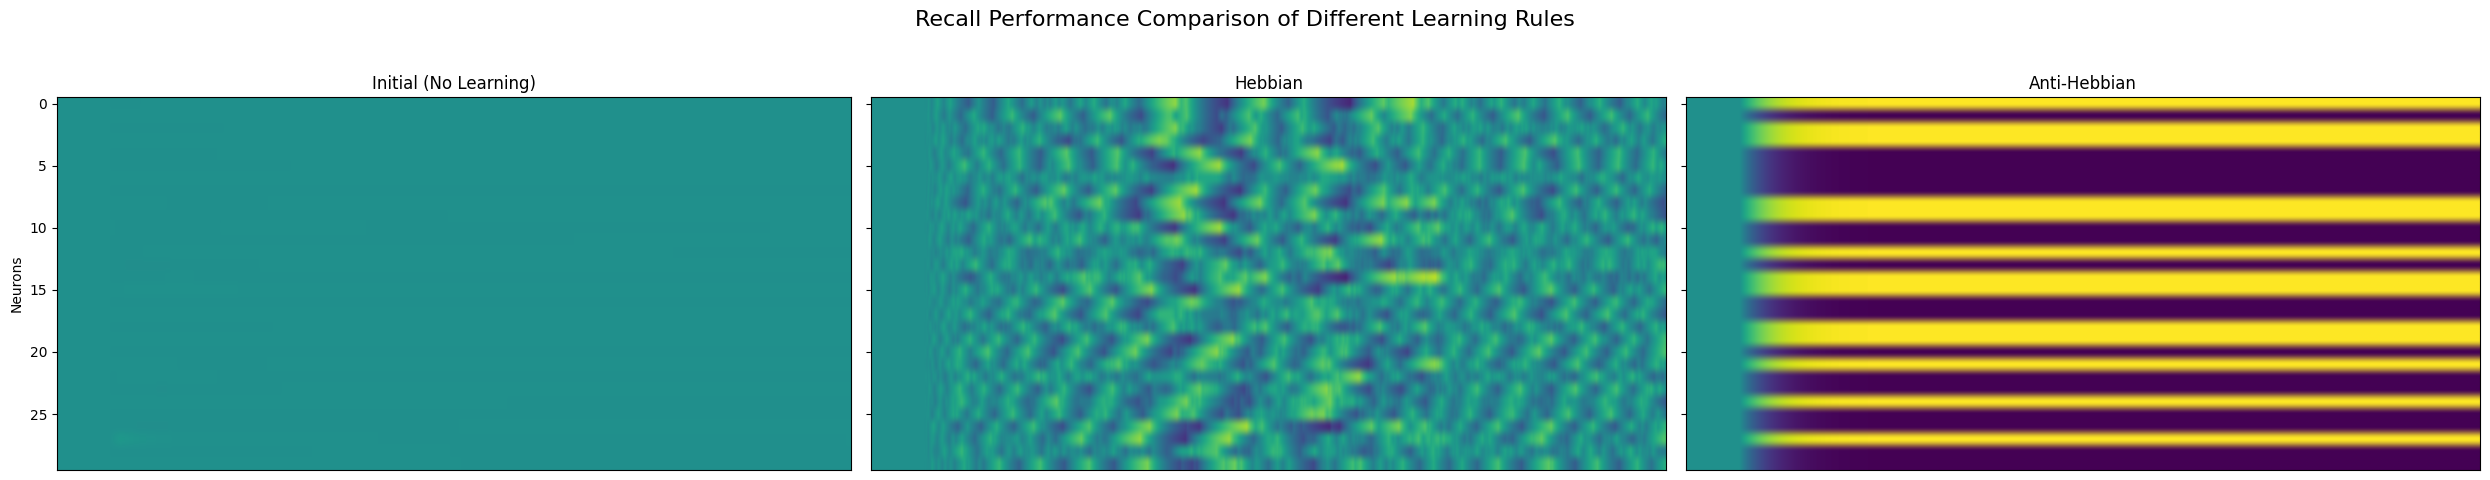

In [ ]:
def run_recall_test(J_matrix):
    test_time = 1500.0
    n_test_timesteps = int(test_time / model['dt'])
    weak_cue_stream = np.zeros((model['nIn'], n_test_timesteps))
    cue_start_idx = int(100 / model['dt'])
    cue_end_idx = int(120 / model['dt'])
    weak_cue_stream[stimulus_id, cue_start_idx:cue_end_idx] = 0.2

    rates = np.zeros((model['N'], n_test_timesteps))
    for t in range(n_test_timesteps - 1):
        r_current = rates[:, t]
        I_synaptic = J_matrix @ r_current
        I_input = Jin @ weak_cue_stream[:, t]
        total_input = I_synaptic + I_input
        r_new = r_current + (model['dt'] / model['tau']) * (-r_current + model['nonlin'](total_input))
        rates[:, t+1] = np.clip(r_new, -1.0, 1.0)
    return rates

print("\nRunning recall tests...")
recall_initial = run_recall_test(J_initial)
recall_hebbian = run_recall_test(J_hebbian)
recall_anti_hebbian = run_recall_test(J_anti_hebbian)
# recall_bcm = run_recall_test(J_bcm)
# recall_stdp = run_recall_test(J_stdp)

fig, axes = plt.subplots(1, 3, figsize=(25, 5), sharey=True)
fig.suptitle("Recall Performance Comparison of Different Learning Rules", fontsize=16)

scenarios = {
    "Initial (No Learning)": recall_initial,
    "Hebbian": recall_anti_hebbian,
    "Anti-Hebbian": recall_hebbian,
    # "BCM": recall_bcm,
    # "STDP (rate-based)": recall_stdp
}

for i, (title, data) in enumerate(scenarios.items()):
    ax = axes[i]
    im = ax.imshow(data, aspect='auto', vmin=-1, vmax=1, cmap='viridis')
    ax.set_title(title)
    ax.set_xticks([])
    if i == 0:
        ax.set_ylabel("Neurons")

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

Starting training with ANTI-HEBBIAN rule...
Training finished.


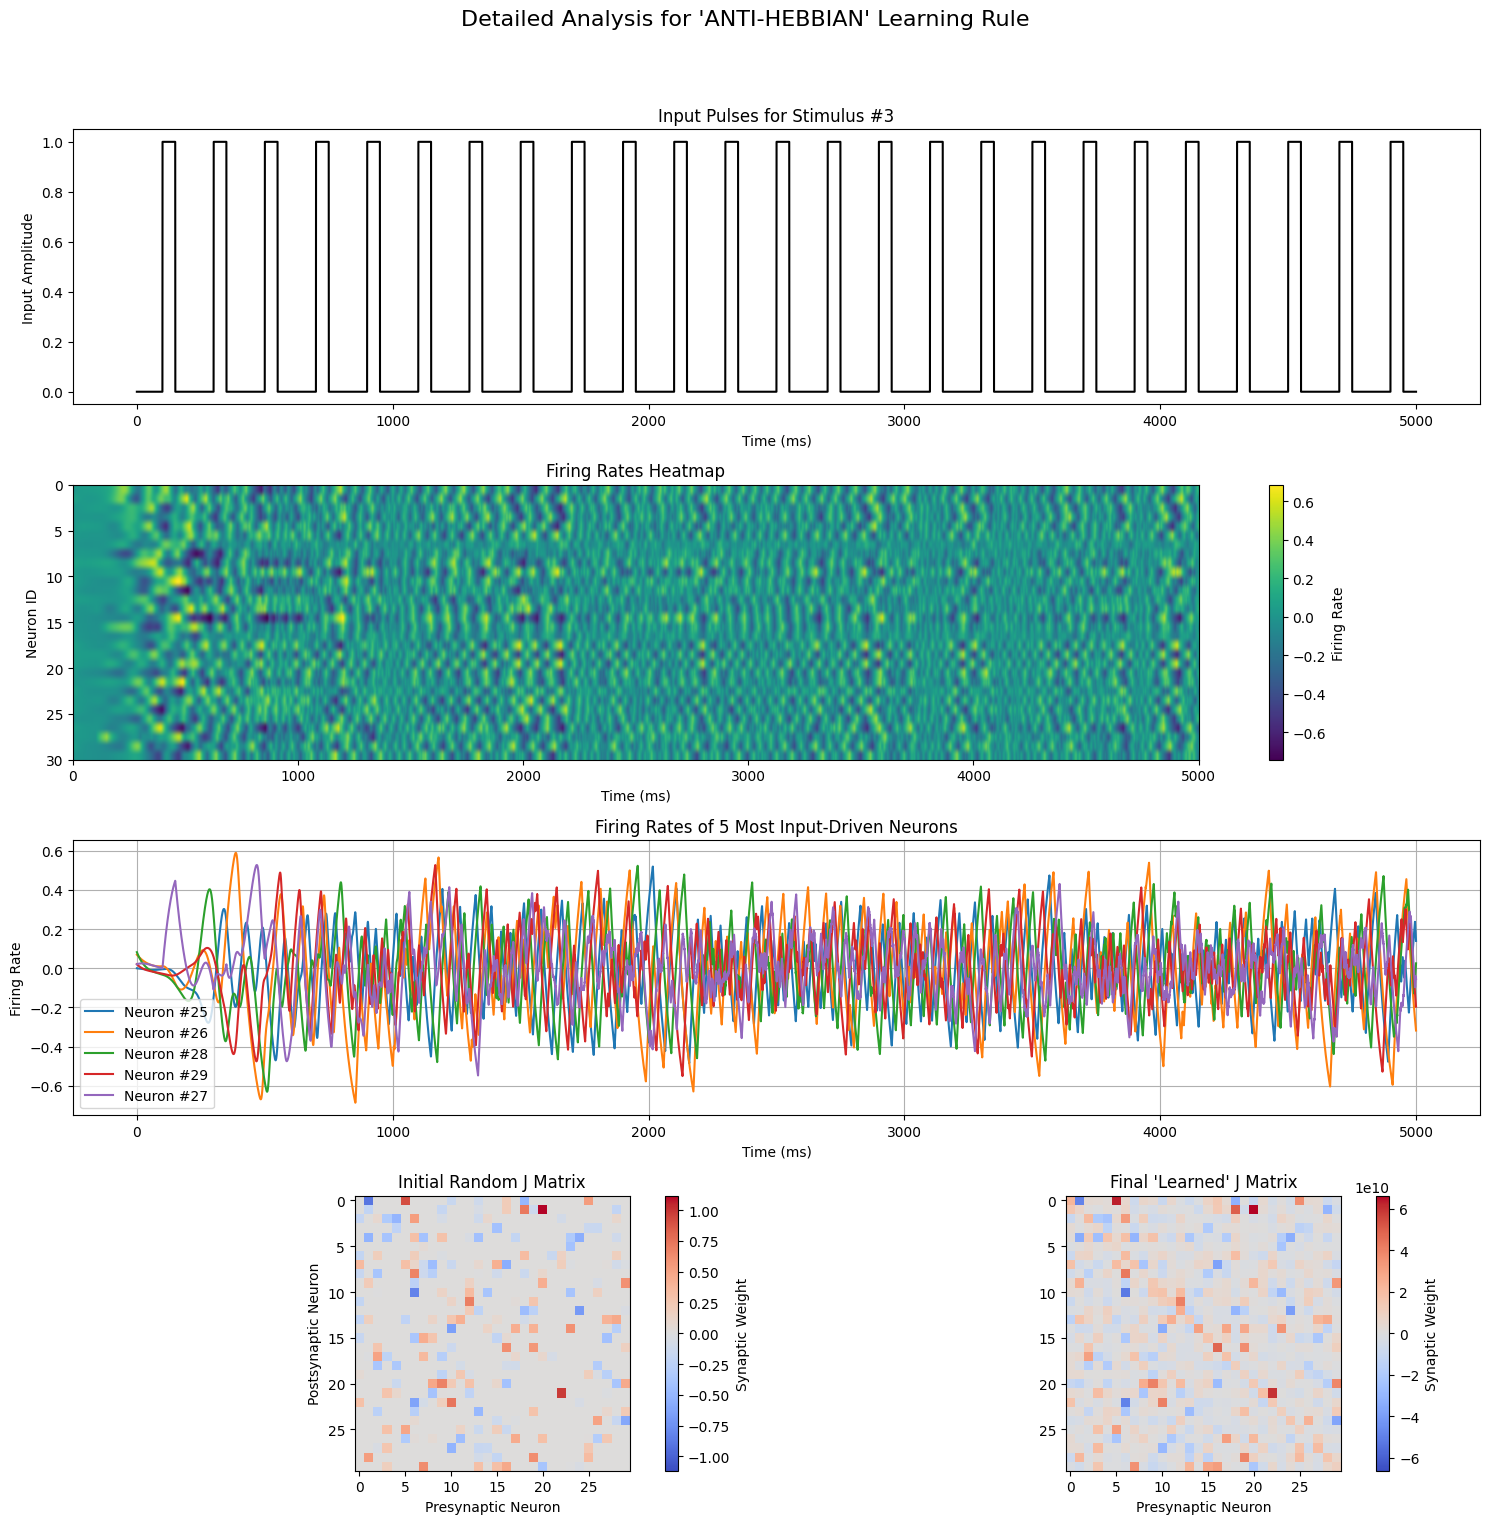

In [ ]:
def analyze_and_visualize_rule(rule_type='hebbian'):
    """
    Re-runs a simulation for a specific rule and creates a detailed
    set of visualizations for its training process.
    """
    # --- 1. Re-run the simulation to get the full data ---
    J_learned = run_learning_simulation(J_initial, rule_type=rule_type)

    # Re-run again to get the firing_rates history
    temp_J = J_initial.copy()
    firing_rates = np.zeros((model['N'], n_timesteps))
    firing_rates[:, 0] = np.random.uniform(0, 0.1, size=(model['N']))

    # if rule_type == 'bcm':
    #     theta = np.zeros(model['N']); lr = 0.02
    # elif rule_type == 'stdp':
    #     lr_ltp = 0.01; lr_ltd = 0.012; tau_trace = 200.0
    #     pre_trace = np.zeros(model['N']); post_trace = np.zeros(model['N'])
    # else:
    lr = 0.005

    for t in range(n_timesteps - 1):
        r_current = firing_rates[:, t]
        I_synaptic = temp_J @ r_current
        I_input = Jin @ input_stream[:, t]
        total_input = I_synaptic + I_input
        r_new = r_current + (model['dt'] / model['tau']) * (-r_current + model['nonlin'](total_input))
        firing_rates[:, t+1] = np.clip(r_new, -1.0, 1.0)

        if rule_type == 'hebbian':
            update = np.outer(firing_rates[:, t+1], r_current)
            temp_J += lr * update - (lr * 0.1) * temp_J
        elif rule_type == 'anti-hebbian':
            update = np.outer(firing_rates[:, t+1], r_current)
            temp_J -= lr * update - (lr * 0.1) * temp_J
        # elif rule_type == 'bcm':
        #     r_post = firing_rates[:, t+1]
        #     phi = r_post * (r_post - theta)
        #     update = np.outer(phi, r_current)
        #     temp_J += lr * update
        #     theta += (model['dt'] / 200.0) * (-theta + r_post**2)
        # elif rule_type == 'stdp':
        #     r_pre = firing_rates[:, t]; r_post = firing_rates[:, t+1]
        #     pre_trace += (model['dt'] / tau_trace) * (-pre_trace + r_pre)
        #     post_trace += (model['dt'] / tau_trace) * (-post_trace + r_post)
        #     LTP = lr_ltp * np.outer(r_post, pre_trace)
        #     LTD = lr_ltd * np.outer(post_trace, r_pre)
        #     temp_J += LTP - LTD

    # --- 2. Generate the Plots ---
    fig = plt.figure(figsize=(15, 16))
    gs = fig.add_gridspec(4, 2)
    timesteps_array = np.arange(n_timesteps) * model['dt']

    fig.suptitle(f"Detailed Analysis for '{rule_type.upper()}' Learning Rule", fontsize=16)

    ax0 = fig.add_subplot(gs[0, :])
    ax0.plot(timesteps_array, input_stream[stimulus_id, :], 'k')
    ax0.set_title(f"Input Pulses for Stimulus #{stimulus_id}")
    ax0.set_xlabel("Time (ms)"); ax0.set_ylabel("Input Amplitude")

    ax1 = fig.add_subplot(gs[1, :])
    im = ax1.imshow(firing_rates, aspect='auto', extent=[0, simulation_time, model['N'], 0])
    ax1.set_title(f"Firing Rates Heatmap"); ax1.set_xlabel("Time (ms)"); ax1.set_ylabel("Neuron ID")
    fig.colorbar(im, ax=ax1, label="Firing Rate")

    ax_line = fig.add_subplot(gs[2, :])
    n_to_plot = 5
    top_neurons = np.argsort(Jin[:, stimulus_id])[-n_to_plot:]
    for i, neuron_idx in enumerate(top_neurons):
        ax_line.plot(timesteps_array, firing_rates[neuron_idx, :], label=f'Neuron #{neuron_idx}')
    ax_line.set_title(f"Firing Rates of {n_to_plot} Most Input-Driven Neurons")
    ax_line.set_xlabel("Time (ms)"); ax_line.set_ylabel("Firing Rate")
    ax_line.legend(); ax_line.grid(True)

    ax2 = fig.add_subplot(gs[3, 0])
    vmax = np.max(np.abs(J_initial))
    im2 = ax2.imshow(-J_initial, cmap='coolwarm', vmin=-vmax, vmax=vmax)
    ax2.set_title("Initial Random J Matrix"); ax2.set_xlabel("Presynaptic Neuron"); ax2.set_ylabel("Postsynaptic Neuron")
    fig.colorbar(im2, ax=ax2, label="Synaptic Weight")

    ax3 = fig.add_subplot(gs[3, 1])
    vmax = np.max(np.abs(J_learned))
    im3 = ax3.imshow(-J_learned, cmap='coolwarm', vmin=-vmax, vmax=vmax)
    ax3.set_title("Final 'Learned' J Matrix"); ax3.set_xlabel("Presynaptic Neuron")
    fig.colorbar(im3, ax=ax3, label="Synaptic Weight")

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

analyze_and_visualize_rule('anti-hebbian')

***Input categories***



In [ ]:
def generate_one_shot_input(nIn, n_timesteps, stim_id, onset_time, duration, dt, amplitude=1.0):
    input_stream = np.zeros((nIn, n_timesteps))
    start = int(onset_time / dt)
    end = int((onset_time + duration) / dt)
    input_stream[stim_id, start:end] = amplitude
    return input_stream


def generate_repeated_input(nIn, n_timesteps, stim_id, dt, interval=500, duration=50, amplitude=1.0, start=100):
    input_stream = np.zeros((nIn, n_timesteps))
    current_time = start
    while current_time + duration < n_timesteps * dt:
        start_idx = int(current_time / dt)
        end_idx = int((current_time + duration) / dt)
        input_stream[stim_id, start_idx:end_idx] = amplitude
        current_time += interval
    return input_stream

def generate_alternating_input(nIn, n_timesteps, stim_ids, dt, interval=500, duration=50, amplitude=1.0, start=100):
    input_stream = np.zeros((nIn, n_timesteps))
    current_time = start
    i = 0
    while current_time + duration < n_timesteps * dt:
        stim_id = stim_ids[i % len(stim_ids)]
        start_idx = int(current_time / dt)
        end_idx = int((current_time + duration) / dt)
        input_stream[stim_id, start_idx:end_idx] = amplitude
        current_time += interval
        i += 1
    return input_stream

def generate_sequence_input(nIn, n_timesteps, stim_ids, dt, base_time=100, delay=100, duration=50, amplitude=1.0):
    input_stream = np.zeros((nIn, n_timesteps))
    for i, stim_id in enumerate(stim_ids):
        start_time = base_time + i * delay
        start_idx = int(start_time / dt)
        end_idx = int((start_time + duration) / dt)
        input_stream[stim_id, start_idx:end_idx] = amplitude
    return input_stream


In [ ]:
stimulus_id = 1
n_timesteps = int(5000 / model['dt'])

Starting training with HEBBIAN rule...
Training finished.
Starting training with ANTI-HEBBIAN rule...
Training finished.
Starting training with BCM rule...
Training finished.
Starting training with STDP rule...
Training finished.

Running recall tests...


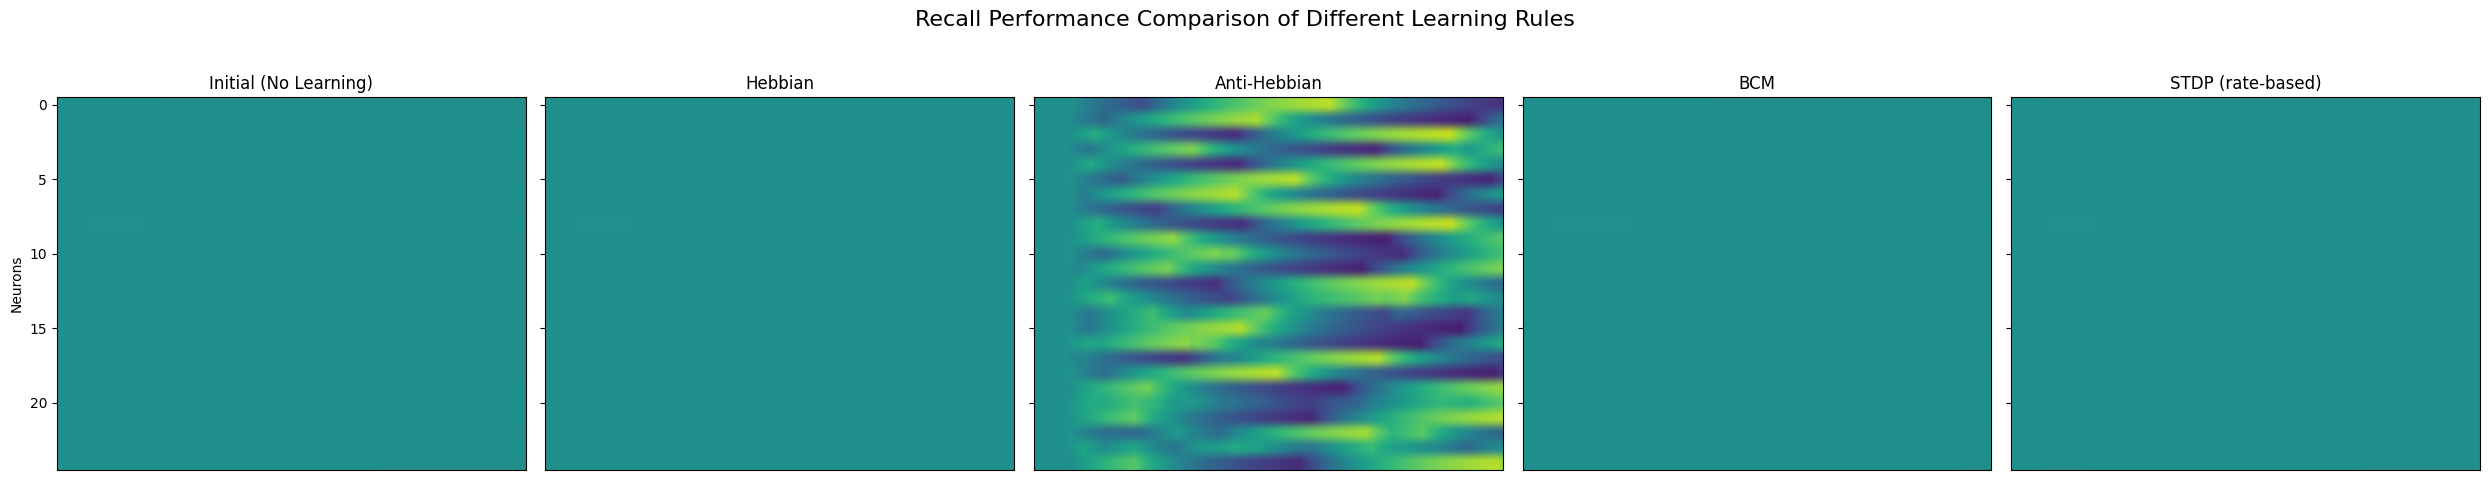

In [ ]:
input_stream = generate_one_shot_input(model['nIn'], n_timesteps, stimulus_id, 100, 50, model['dt'])

def run_learning_simulation(J0, rule_type='hebbian'):
    J = J0.copy()
    firing_rates = np.zeros((model['N'], n_timesteps))
    firing_rates[:, 0] = np.random.uniform(0, 0.1, size=(model['N']))

    # Parameters for rules
    if rule_type == 'bcm':
        theta = np.zeros(model['N']) # BCM threshold
        lr = 0.02
    elif rule_type == 'stdp':
        lr_ltp = 0.01  # Learning rate for potentiation
        lr_ltd = 0.012 # Learning rate for depression
        tau_trace = 200.0 # Time constant for synaptic traces in ms
        pre_trace = np.zeros(model['N'])
        post_trace = np.zeros(model['N'])
    else: # hebbian or anti-hebbian
        lr = 0.005

    print(f"Starting training with {rule_type.upper()} rule...")
    for t in range(n_timesteps - 1):
        r_current = firing_rates[:, t]
        I_synaptic = J @ r_current
        I_input = Jin @ input_stream[:, t]
        total_input = I_synaptic + I_input
        r_new = r_current + (model['dt'] / model['tau']) * (-r_current + model['nonlin'](total_input))
        firing_rates[:, t+1] = np.clip(r_new, -1.0, 1.0)

        if rule_type == 'hebbian':
            update = np.outer(firing_rates[:, t+1], r_current)
            J += lr * update - (lr * 0.1) * J

        elif rule_type == 'anti-hebbian':
            update = np.outer(firing_rates[:, t+1], r_current)
            J -= lr * update - (lr * 0.1) * J

        elif rule_type == 'bcm':
            r_post = firing_rates[:, t+1]
            phi = r_post * (r_post - theta)
            update = np.outer(phi, r_current)
            J += lr * update
            theta += (model['dt'] / 200.0) * (-theta + r_post**2)

        elif rule_type == 'stdp':
            r_pre = firing_rates[:, t]
            r_post = firing_rates[:, t+1]

            # Update synaptic traces
            pre_trace += (model['dt'] / tau_trace) * (-pre_trace + r_pre)
            post_trace += (model['dt'] / tau_trace) * (-post_trace + r_post)

            # Calculate potentiation (LTP) and depression (LTD)
            LTP = lr_ltp * np.outer(r_post, pre_trace)
            LTD = lr_ltd * np.outer(post_trace, r_pre)

            # Apply the update
            J += LTP - LTD

    print("Training finished.")
    return J

J_hebbian = run_learning_simulation(J_initial, 'hebbian')
J_anti_hebbian = run_learning_simulation(J_initial, 'anti-hebbian')
J_bcm = run_learning_simulation(J_initial, 'bcm')
J_stdp = run_learning_simulation(J_initial, 'stdp')

def run_recall_test(J_matrix):
    test_time = 1500.0
    n_test_timesteps = int(test_time / model['dt'])
    weak_cue_stream = np.zeros((model['nIn'], n_test_timesteps))
    cue_start_idx = int(100 / model['dt'])
    cue_end_idx = int(120 / model['dt'])
    weak_cue_stream[stimulus_id, cue_start_idx:cue_end_idx] = 0.2

    rates = np.zeros((model['N'], n_test_timesteps))
    for t in range(n_test_timesteps - 1):
        r_current = rates[:, t]
        I_synaptic = J_matrix @ r_current
        I_input = Jin @ weak_cue_stream[:, t]
        total_input = I_synaptic + I_input
        r_new = r_current + (model['dt'] / model['tau']) * (-r_current + model['nonlin'](total_input))
        rates[:, t+1] = np.clip(r_new, -1.0, 1.0)
    return rates

print("\nRunning recall tests...")
recall_initial = run_recall_test(J_initial)
recall_hebbian = run_recall_test(J_hebbian)
recall_anti_hebbian = run_recall_test(J_anti_hebbian)
recall_bcm = run_recall_test(J_bcm)
recall_stdp = run_recall_test(J_stdp)

fig, axes = plt.subplots(1, 5, figsize=(25, 5), sharey=True)
fig.suptitle("Recall Performance Comparison of Different Learning Rules", fontsize=16)

scenarios = {
    "Initial (No Learning)": recall_initial,
    "Hebbian": recall_hebbian,
    "Anti-Hebbian": recall_anti_hebbian,
    "BCM": recall_bcm,
    "STDP (rate-based)": recall_stdp
}

for i, (title, data) in enumerate(scenarios.items()):
    ax = axes[i]
    im = ax.imshow(data, aspect='auto', vmin=-1, vmax=1, cmap='viridis')
    ax.set_title(title)
    ax.set_xticks([])
    if i == 0:
        ax.set_ylabel("Neurons")

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

Starting training with HEBBIAN rule...
Training finished.


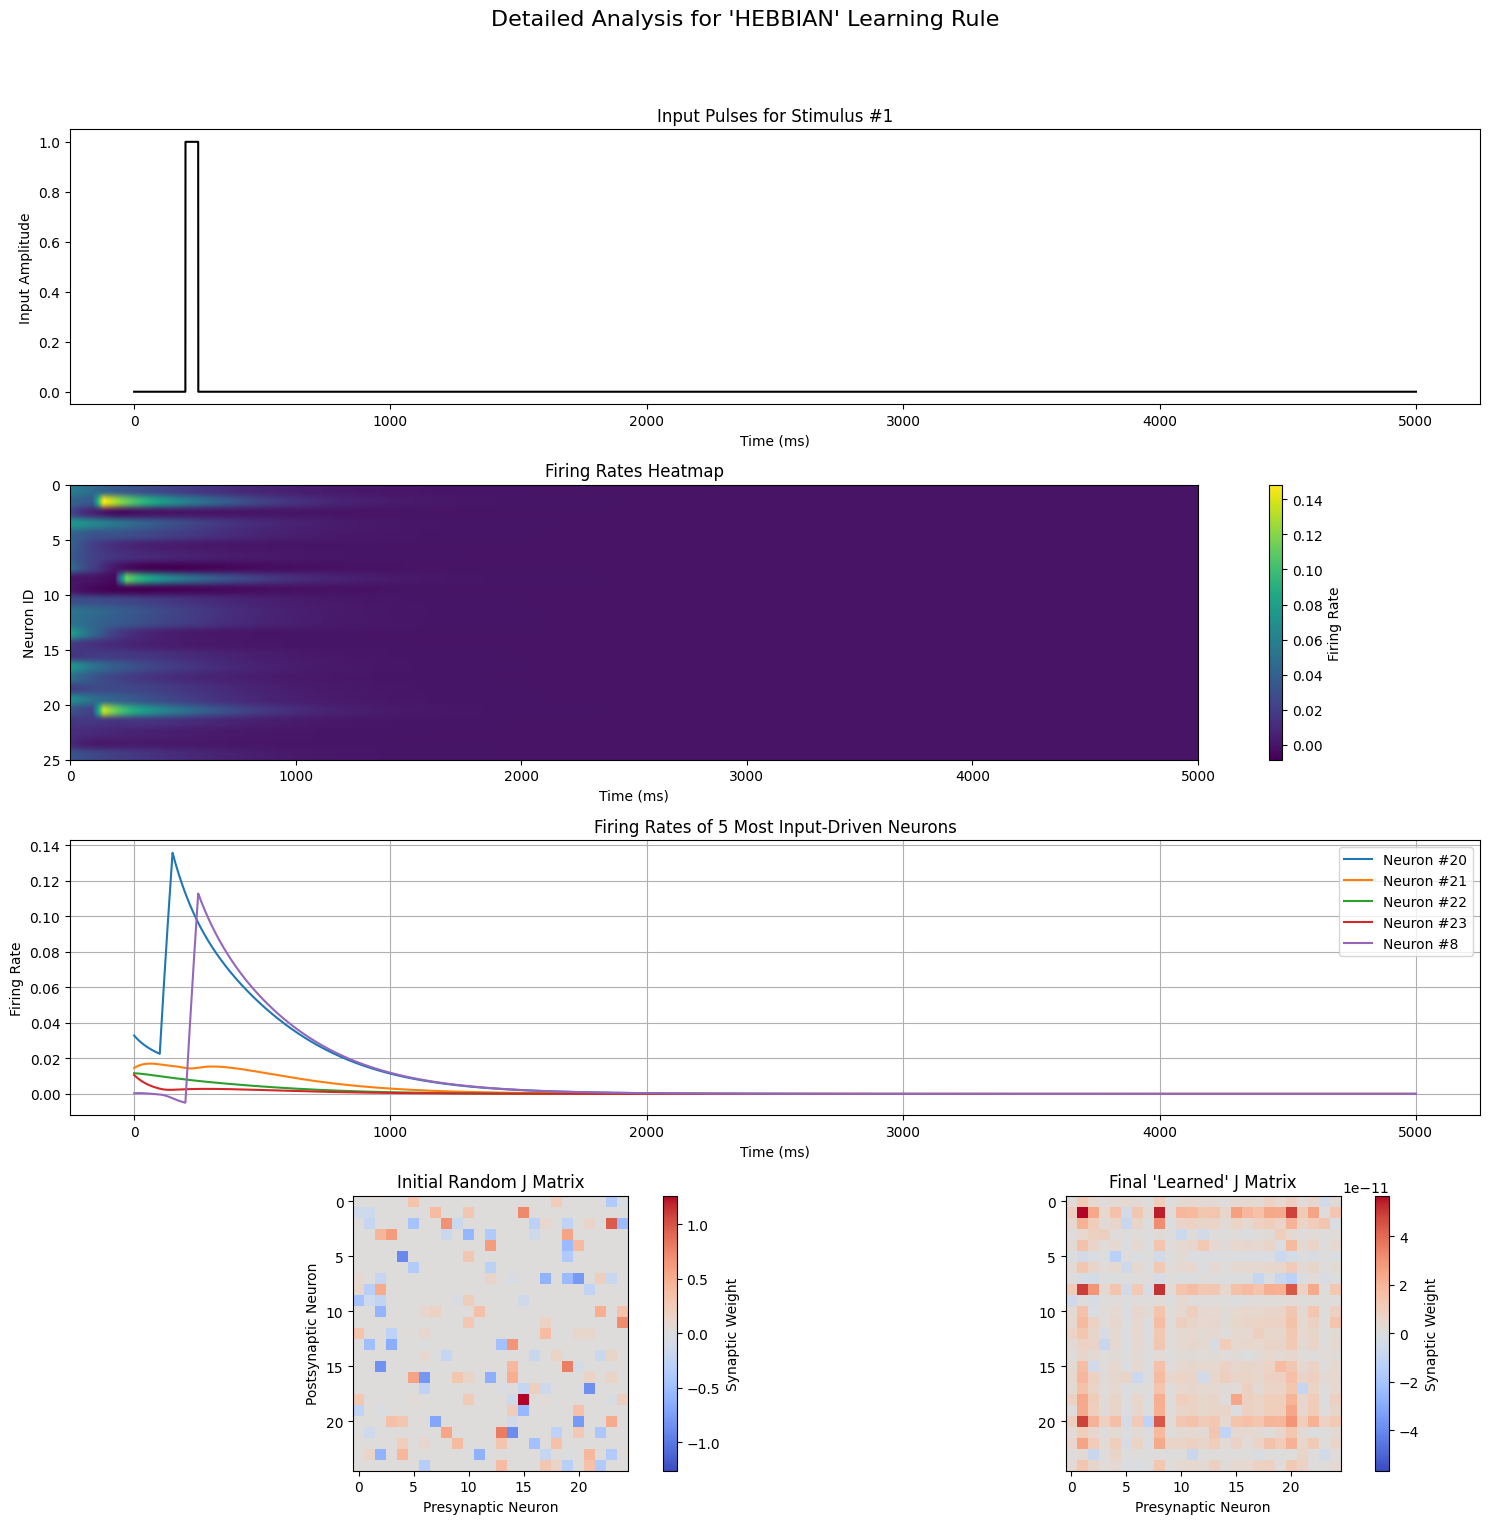

In [ ]:
def analyze_and_visualize_rule(rule_type='hebbian'):
    """
    Re-runs a simulation for a specific rule and creates a detailed
    set of visualizations for its training process.
    """
    # --- 1. Re-run the simulation to get the full data ---
    J_learned = run_learning_simulation(J_initial, rule_type=rule_type)

    # Re-run again to get the firing_rates history
    temp_J = J_initial.copy()
    firing_rates = np.zeros((model['N'], n_timesteps))
    firing_rates[:, 0] = np.random.uniform(0, 0.1, size=(model['N']))

    if rule_type == 'bcm':
        theta = np.zeros(model['N']); lr = 0.02
    elif rule_type == 'stdp':
        lr_ltp = 0.01; lr_ltd = 0.012; tau_trace = 200.0
        pre_trace = np.zeros(model['N']); post_trace = np.zeros(model['N'])
    else:
        lr = 0.005

    for t in range(n_timesteps - 1):
        r_current = firing_rates[:, t]
        I_synaptic = temp_J @ r_current
        I_input = Jin @ input_stream[:, t]
        total_input = I_synaptic + I_input
        r_new = r_current + (model['dt'] / model['tau']) * (-r_current + model['nonlin'](total_input))
        firing_rates[:, t+1] = np.clip(r_new, -1.0, 1.0)

        if rule_type == 'hebbian':
            update = np.outer(firing_rates[:, t+1], r_current)
            temp_J += lr * update - (lr * 0.1) * temp_J
        elif rule_type == 'anti-hebbian':
            update = np.outer(firing_rates[:, t+1], r_current)
            temp_J -= lr * update - (lr * 0.1) * temp_J
        elif rule_type == 'bcm':
            r_post = firing_rates[:, t+1]
            phi = r_post * (r_post - theta)
            update = np.outer(phi, r_current)
            temp_J += lr * update
            theta += (model['dt'] / 200.0) * (-theta + r_post**2)
        elif rule_type == 'stdp':
            r_pre = firing_rates[:, t]; r_post = firing_rates[:, t+1]
            pre_trace += (model['dt'] / tau_trace) * (-pre_trace + r_pre)
            post_trace += (model['dt'] / tau_trace) * (-post_trace + r_post)
            LTP = lr_ltp * np.outer(r_post, pre_trace)
            LTD = lr_ltd * np.outer(post_trace, r_pre)
            temp_J += LTP - LTD

    # --- 2. Generate the Plots ---
    fig = plt.figure(figsize=(15, 16))
    gs = fig.add_gridspec(4, 2)
    timesteps_array = np.arange(n_timesteps) * model['dt']

    fig.suptitle(f"Detailed Analysis for '{rule_type.upper()}' Learning Rule", fontsize=16)

    ax0 = fig.add_subplot(gs[0, :])
    ax0.plot(timesteps_array, input_stream[stimulus_id, :], 'k')
    ax0.set_title(f"Input Pulses for Stimulus #{stimulus_id}")
    ax0.set_xlabel("Time (ms)"); ax0.set_ylabel("Input Amplitude")

    ax1 = fig.add_subplot(gs[1, :])
    im = ax1.imshow(firing_rates, aspect='auto', extent=[0, simulation_time, model['N'], 0])
    ax1.set_title(f"Firing Rates Heatmap"); ax1.set_xlabel("Time (ms)"); ax1.set_ylabel("Neuron ID")
    fig.colorbar(im, ax=ax1, label="Firing Rate")

    ax_line = fig.add_subplot(gs[2, :])
    n_to_plot = 5
    top_neurons = np.argsort(Jin[:, stimulus_id])[-n_to_plot:]
    for i, neuron_idx in enumerate(top_neurons):
        ax_line.plot(timesteps_array, firing_rates[neuron_idx, :], label=f'Neuron #{neuron_idx}')
    ax_line.set_title(f"Firing Rates of {n_to_plot} Most Input-Driven Neurons")
    ax_line.set_xlabel("Time (ms)"); ax_line.set_ylabel("Firing Rate")
    ax_line.legend(); ax_line.grid(True)

    ax2 = fig.add_subplot(gs[3, 0])
    vmax = np.max(np.abs(J_initial))
    im2 = ax2.imshow(J_initial, cmap='coolwarm', vmin=-vmax, vmax=vmax)
    ax2.set_title("Initial Random J Matrix"); ax2.set_xlabel("Presynaptic Neuron"); ax2.set_ylabel("Postsynaptic Neuron")
    fig.colorbar(im2, ax=ax2, label="Synaptic Weight")

    ax3 = fig.add_subplot(gs[3, 1])
    vmax = np.max(np.abs(J_learned))
    im3 = ax3.imshow(J_learned, cmap='coolwarm', vmin=-vmax, vmax=vmax)
    ax3.set_title("Final 'Learned' J Matrix"); ax3.set_xlabel("Presynaptic Neuron")
    fig.colorbar(im3, ax=ax3, label="Synaptic Weight")

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

# --- Run the analysis for the 'stdp' rule ---
analyze_and_visualize_rule('hebbian')

Starting training with HEBBIAN rule...
Training finished.
Starting training with ANTI-HEBBIAN rule...
Training finished.
Starting training with BCM rule...
Training finished.
Starting training with STDP rule...
Training finished.

Running recall tests...


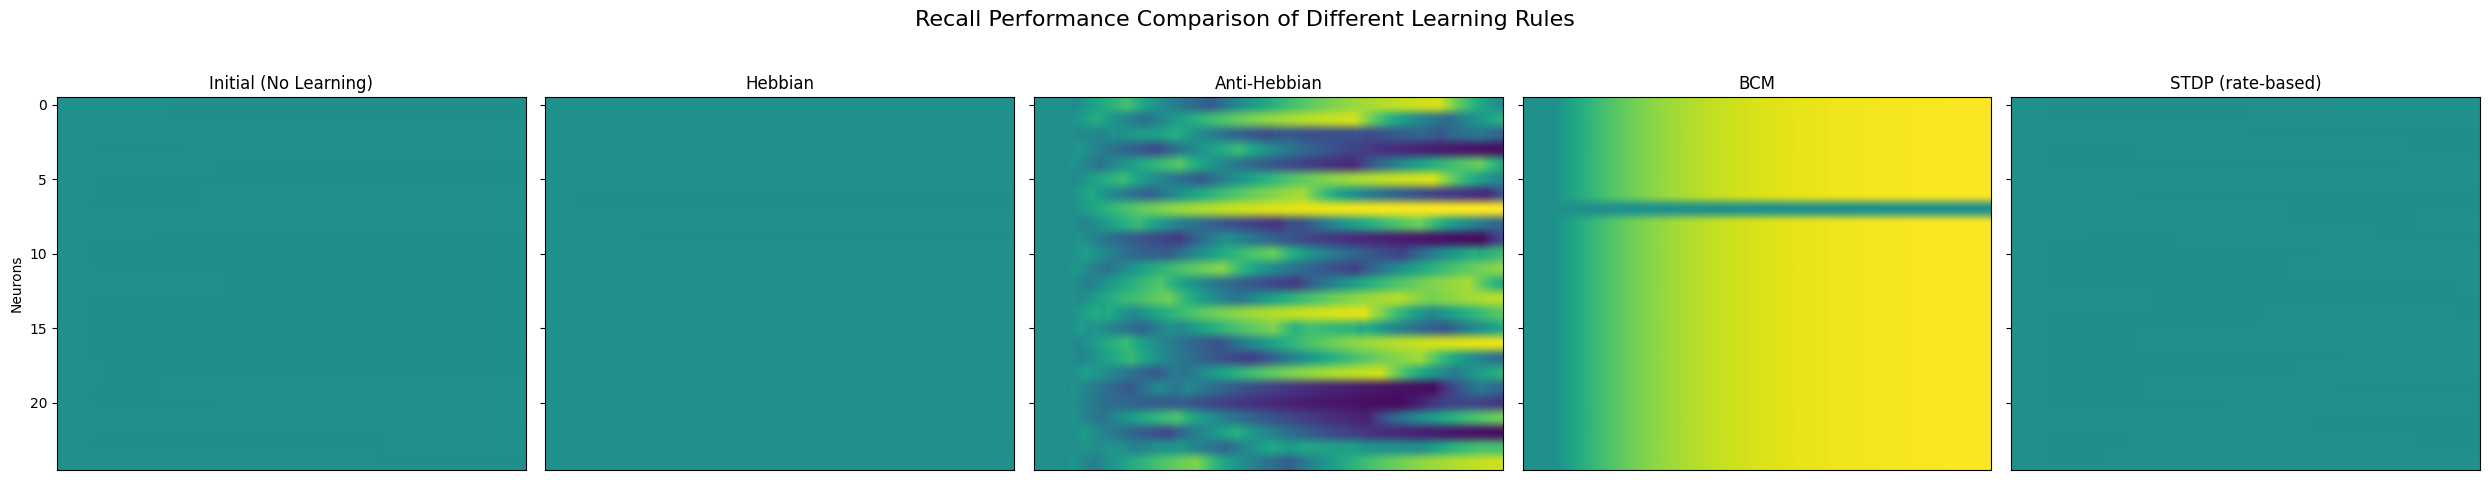

In [ ]:
input_stream = generate_repeated_input(model['nIn'], n_timesteps, stimulus_id, model['dt'])


def run_learning_simulation(J0, rule_type='hebbian'):
    J = J0.copy()
    firing_rates = np.zeros((model['N'], n_timesteps))
    firing_rates[:, 0] = np.random.uniform(0, 0.1, size=(model['N']))

    # Parameters for rules
    if rule_type == 'bcm':
        theta = np.zeros(model['N']) # BCM threshold
        lr = 0.02
    elif rule_type == 'stdp':
        lr_ltp = 0.01  # Learning rate for potentiation
        lr_ltd = 0.012 # Learning rate for depression
        tau_trace = 200.0 # Time constant for synaptic traces in ms
        pre_trace = np.zeros(model['N'])
        post_trace = np.zeros(model['N'])
    else: # hebbian or anti-hebbian
        lr = 0.005

    print(f"Starting training with {rule_type.upper()} rule...")
    for t in range(n_timesteps - 1):
        r_current = firing_rates[:, t]
        I_synaptic = J @ r_current
        I_input = Jin @ input_stream[:, t]
        total_input = I_synaptic + I_input
        r_new = r_current + (model['dt'] / model['tau']) * (-r_current + model['nonlin'](total_input))
        firing_rates[:, t+1] = np.clip(r_new, -1.0, 1.0)

        if rule_type == 'hebbian':
            update = np.outer(firing_rates[:, t+1], r_current)
            J += lr * update - (lr * 0.1) * J

        elif rule_type == 'anti-hebbian':
            update = np.outer(firing_rates[:, t+1], r_current)
            J -= lr * update - (lr * 0.1) * J

        elif rule_type == 'bcm':
            r_post = firing_rates[:, t+1]
            phi = r_post * (r_post - theta)
            update = np.outer(phi, r_current)
            J += lr * update
            theta += (model['dt'] / 200.0) * (-theta + r_post**2)

        elif rule_type == 'stdp':
            r_pre = firing_rates[:, t]
            r_post = firing_rates[:, t+1]

            # Update synaptic traces
            pre_trace += (model['dt'] / tau_trace) * (-pre_trace + r_pre)
            post_trace += (model['dt'] / tau_trace) * (-post_trace + r_post)

            # Calculate potentiation (LTP) and depression (LTD)
            LTP = lr_ltp * np.outer(r_post, pre_trace)
            LTD = lr_ltd * np.outer(post_trace, r_pre)

            # Apply the update
            J += LTP - LTD

    print("Training finished.")
    return J

J_hebbian = run_learning_simulation(J_initial, 'hebbian')
J_anti_hebbian = run_learning_simulation(J_initial, 'anti-hebbian')
J_bcm = run_learning_simulation(J_initial, 'bcm')
J_stdp = run_learning_simulation(J_initial, 'stdp')

def run_recall_test(J_matrix):
    test_time = 1500.0
    n_test_timesteps = int(test_time / model['dt'])
    weak_cue_stream = np.zeros((model['nIn'], n_test_timesteps))
    cue_start_idx = int(100 / model['dt'])
    cue_end_idx = int(120 / model['dt'])
    weak_cue_stream[stimulus_id, cue_start_idx:cue_end_idx] = 0.2

    rates = np.zeros((model['N'], n_test_timesteps))
    for t in range(n_test_timesteps - 1):
        r_current = rates[:, t]
        I_synaptic = J_matrix @ r_current
        I_input = Jin @ weak_cue_stream[:, t]
        total_input = I_synaptic + I_input
        r_new = r_current + (model['dt'] / model['tau']) * (-r_current + model['nonlin'](total_input))
        rates[:, t+1] = np.clip(r_new, -1.0, 1.0)
    return rates

print("\nRunning recall tests...")
recall_initial = run_recall_test(J_initial)
recall_hebbian = run_recall_test(J_hebbian)
recall_anti_hebbian = run_recall_test(J_anti_hebbian)
recall_bcm = run_recall_test(J_bcm)
recall_stdp = run_recall_test(J_stdp)

fig, axes = plt.subplots(1, 5, figsize=(25, 5), sharey=True)
fig.suptitle("Recall Performance Comparison of Different Learning Rules", fontsize=16)

scenarios = {
    "Initial (No Learning)": recall_initial,
    "Hebbian": recall_hebbian,
    "Anti-Hebbian": recall_anti_hebbian,
    "BCM": recall_bcm,
    "STDP (rate-based)": recall_stdp
}

for i, (title, data) in enumerate(scenarios.items()):
    ax = axes[i]
    im = ax.imshow(data, aspect='auto', vmin=-1, vmax=1, cmap='viridis')
    ax.set_title(title)
    ax.set_xticks([])
    if i == 0:
        ax.set_ylabel("Neurons")

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

Starting training with HEBBIAN rule...
Training finished.


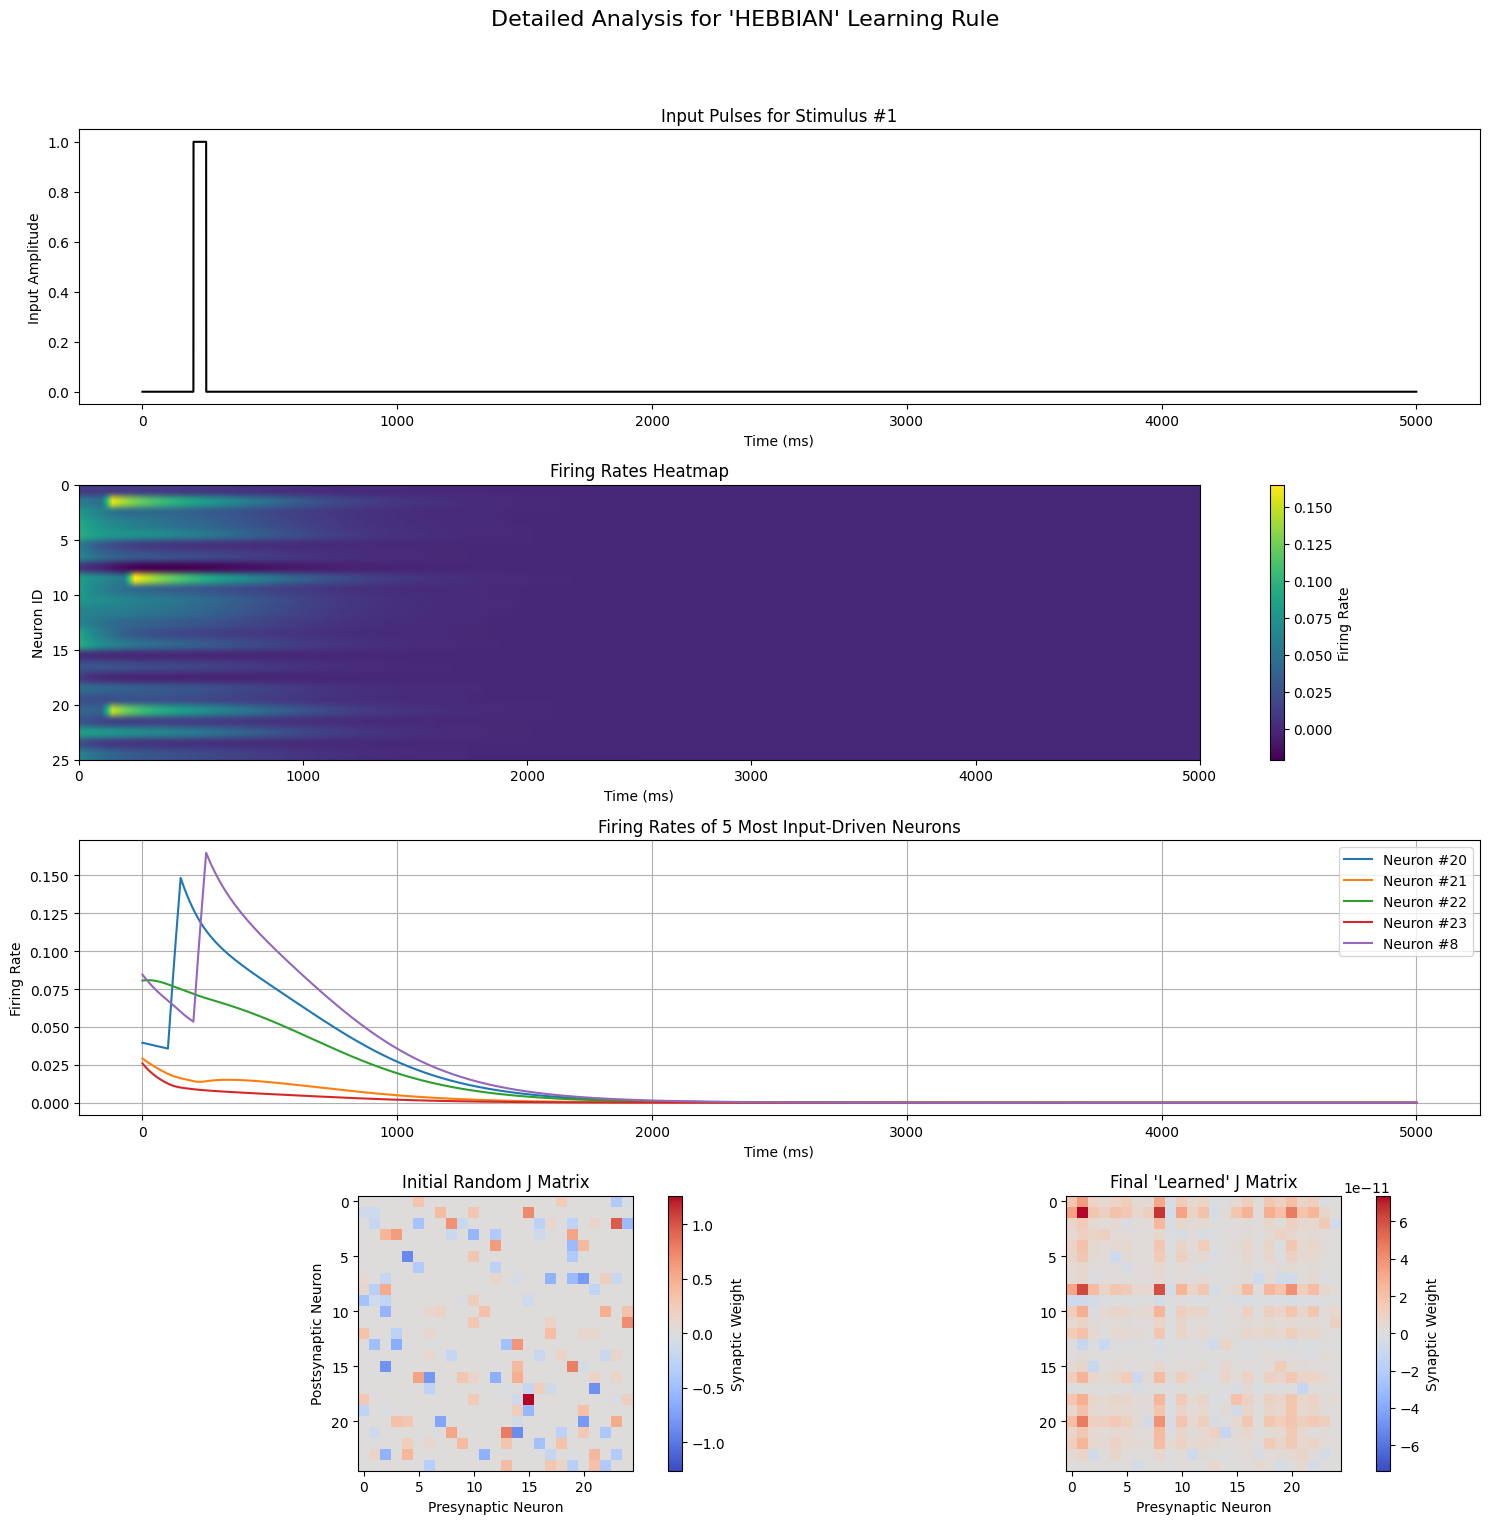

In [ ]:
def analyze_and_visualize_rule(rule_type='BCM'):
    """
    Re-runs a simulation for a specific rule and creates a detailed
    set of visualizations for its training process.
    """
    # --- 1. Re-run the simulation to get the full data ---
    J_learned = run_learning_simulation(J_initial, rule_type=rule_type)

    # Re-run again to get the firing_rates history
    temp_J = J_initial.copy()
    firing_rates = np.zeros((model['N'], n_timesteps))
    firing_rates[:, 0] = np.random.uniform(0, 0.1, size=(model['N']))

    if rule_type == 'bcm':
        theta = np.zeros(model['N']); lr = 0.02
    elif rule_type == 'stdp':
        lr_ltp = 0.01; lr_ltd = 0.012; tau_trace = 200.0
        pre_trace = np.zeros(model['N']); post_trace = np.zeros(model['N'])
    else:
        lr = 0.005

    for t in range(n_timesteps - 1):
        r_current = firing_rates[:, t]
        I_synaptic = temp_J @ r_current
        I_input = Jin @ input_stream[:, t]
        total_input = I_synaptic + I_input
        r_new = r_current + (model['dt'] / model['tau']) * (-r_current + model['nonlin'](total_input))
        firing_rates[:, t+1] = np.clip(r_new, -1.0, 1.0)

        if rule_type == 'hebbian':
            update = np.outer(firing_rates[:, t+1], r_current)
            temp_J += lr * update - (lr * 0.1) * temp_J
        elif rule_type == 'anti-hebbian':
            update = np.outer(firing_rates[:, t+1], r_current)
            temp_J -= lr * update - (lr * 0.1) * temp_J
        elif rule_type == 'bcm':
            r_post = firing_rates[:, t+1]
            phi = r_post * (r_post - theta)
            update = np.outer(phi, r_current)
            temp_J += lr * update
            theta += (model['dt'] / 200.0) * (-theta + r_post**2)
        elif rule_type == 'stdp':
            r_pre = firing_rates[:, t]; r_post = firing_rates[:, t+1]
            pre_trace += (model['dt'] / tau_trace) * (-pre_trace + r_pre)
            post_trace += (model['dt'] / tau_trace) * (-post_trace + r_post)
            LTP = lr_ltp * np.outer(r_post, pre_trace)
            LTD = lr_ltd * np.outer(post_trace, r_pre)
            temp_J += LTP - LTD

    # --- 2. Generate the Plots ---
    fig = plt.figure(figsize=(15, 16))
    gs = fig.add_gridspec(4, 2)
    timesteps_array = np.arange(n_timesteps) * model['dt']

    fig.suptitle(f"Detailed Analysis for '{rule_type.upper()}' Learning Rule", fontsize=16)

    ax0 = fig.add_subplot(gs[0, :])
    ax0.plot(timesteps_array, input_stream[stimulus_id, :], 'k')
    ax0.set_title(f"Input Pulses for Stimulus #{stimulus_id}")
    ax0.set_xlabel("Time (ms)"); ax0.set_ylabel("Input Amplitude")

    ax1 = fig.add_subplot(gs[1, :])
    im = ax1.imshow(firing_rates, aspect='auto', extent=[0, simulation_time, model['N'], 0])
    ax1.set_title(f"Firing Rates Heatmap"); ax1.set_xlabel("Time (ms)"); ax1.set_ylabel("Neuron ID")
    fig.colorbar(im, ax=ax1, label="Firing Rate")

    ax_line = fig.add_subplot(gs[2, :])
    n_to_plot = 5
    top_neurons = np.argsort(Jin[:, stimulus_id])[-n_to_plot:]
    for i, neuron_idx in enumerate(top_neurons):
        ax_line.plot(timesteps_array, firing_rates[neuron_idx, :], label=f'Neuron #{neuron_idx}')
    ax_line.set_title(f"Firing Rates of {n_to_plot} Most Input-Driven Neurons")
    ax_line.set_xlabel("Time (ms)"); ax_line.set_ylabel("Firing Rate")
    ax_line.legend(); ax_line.grid(True)

    ax2 = fig.add_subplot(gs[3, 0])
    vmax = np.max(np.abs(J_initial))
    im2 = ax2.imshow(J_initial, cmap='coolwarm', vmin=-vmax, vmax=vmax)
    ax2.set_title("Initial Random J Matrix"); ax2.set_xlabel("Presynaptic Neuron"); ax2.set_ylabel("Postsynaptic Neuron")
    fig.colorbar(im2, ax=ax2, label="Synaptic Weight")

    ax3 = fig.add_subplot(gs[3, 1])
    vmax = np.max(np.abs(J_learned))
    im3 = ax3.imshow(J_learned, cmap='coolwarm', vmin=-vmax, vmax=vmax)
    ax3.set_title("Final 'Learned' J Matrix"); ax3.set_xlabel("Presynaptic Neuron")
    fig.colorbar(im3, ax=ax3, label="Synaptic Weight")

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

# --- Run the analysis for the 'stdp' rule ---
analyze_and_visualize_rule('hebbian')

Starting training with HEBBIAN rule...
Training finished.
Starting training with ANTI-HEBBIAN rule...
Training finished.
Starting training with BCM rule...
Training finished.
Starting training with STDP rule...
Training finished.

Running recall tests...


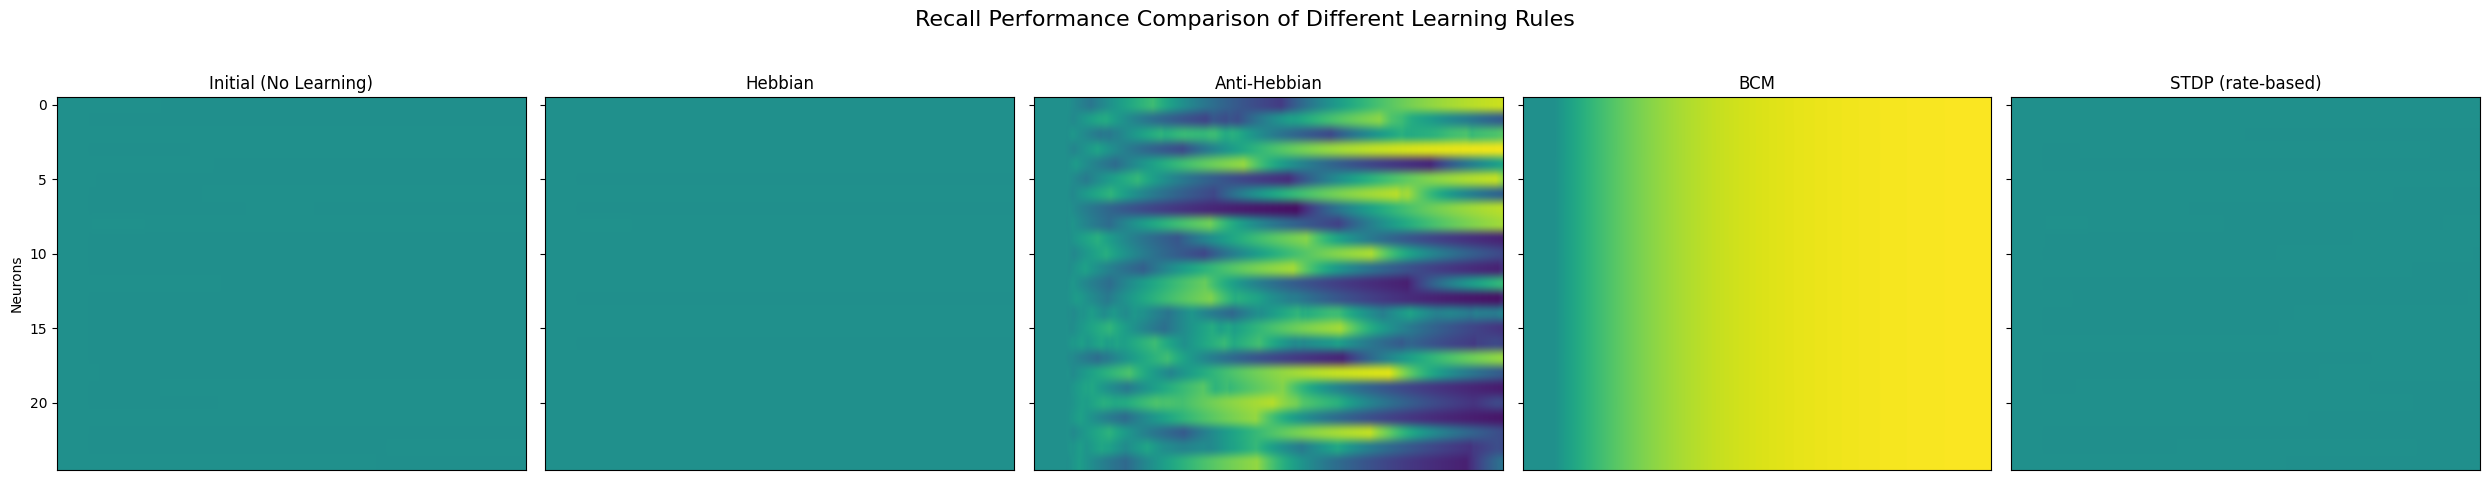

In [ ]:
input_stream = generate_alternating_input(model['nIn'], n_timesteps, [0, 1], model['dt'])


def run_learning_simulation(J0, rule_type='hebbian'):
    J = J0.copy()
    firing_rates = np.zeros((model['N'], n_timesteps))
    firing_rates[:, 0] = np.random.uniform(0, 0.1, size=(model['N']))

    # Parameters for rules
    if rule_type == 'bcm':
        theta = np.zeros(model['N']) # BCM threshold
        lr = 0.02
    elif rule_type == 'stdp':
        lr_ltp = 0.01  # Learning rate for potentiation
        lr_ltd = 0.012 # Learning rate for depression
        tau_trace = 200.0 # Time constant for synaptic traces in ms
        pre_trace = np.zeros(model['N'])
        post_trace = np.zeros(model['N'])
    else: # hebbian or anti-hebbian
        lr = 0.005

    print(f"Starting training with {rule_type.upper()} rule...")
    for t in range(n_timesteps - 1):
        r_current = firing_rates[:, t]
        I_synaptic = J @ r_current
        I_input = Jin @ input_stream[:, t]
        total_input = I_synaptic + I_input
        r_new = r_current + (model['dt'] / model['tau']) * (-r_current + model['nonlin'](total_input))
        firing_rates[:, t+1] = np.clip(r_new, -1.0, 1.0)

        if rule_type == 'hebbian':
            update = np.outer(firing_rates[:, t+1], r_current)
            J += lr * update - (lr * 0.1) * J

        elif rule_type == 'anti-hebbian':
            update = np.outer(firing_rates[:, t+1], r_current)
            J -= lr * update - (lr * 0.1) * J

        elif rule_type == 'bcm':
            r_post = firing_rates[:, t+1]
            phi = r_post * (r_post - theta)
            update = np.outer(phi, r_current)
            J += lr * update
            theta += (model['dt'] / 200.0) * (-theta + r_post**2)

        elif rule_type == 'stdp':
            r_pre = firing_rates[:, t]
            r_post = firing_rates[:, t+1]

            # Update synaptic traces
            pre_trace += (model['dt'] / tau_trace) * (-pre_trace + r_pre)
            post_trace += (model['dt'] / tau_trace) * (-post_trace + r_post)

            # Calculate potentiation (LTP) and depression (LTD)
            LTP = lr_ltp * np.outer(r_post, pre_trace)
            LTD = lr_ltd * np.outer(post_trace, r_pre)

            # Apply the update
            J += LTP - LTD

    print("Training finished.")
    return J

J_hebbian = run_learning_simulation(J_initial, 'hebbian')
J_anti_hebbian = run_learning_simulation(J_initial, 'anti-hebbian')
J_bcm = run_learning_simulation(J_initial, 'bcm')
J_stdp = run_learning_simulation(J_initial, 'stdp')

def run_recall_test(J_matrix):
    test_time = 1500.0
    n_test_timesteps = int(test_time / model['dt'])
    weak_cue_stream = np.zeros((model['nIn'], n_test_timesteps))
    cue_start_idx = int(100 / model['dt'])
    cue_end_idx = int(120 / model['dt'])
    weak_cue_stream[stimulus_id, cue_start_idx:cue_end_idx] = 0.2

    rates = np.zeros((model['N'], n_test_timesteps))
    for t in range(n_test_timesteps - 1):
        r_current = rates[:, t]
        I_synaptic = J_matrix @ r_current
        I_input = Jin @ weak_cue_stream[:, t]
        total_input = I_synaptic + I_input
        r_new = r_current + (model['dt'] / model['tau']) * (-r_current + model['nonlin'](total_input))
        rates[:, t+1] = np.clip(r_new, -1.0, 1.0)
    return rates

print("\nRunning recall tests...")
recall_initial = run_recall_test(J_initial)
recall_hebbian = run_recall_test(J_hebbian)
recall_anti_hebbian = run_recall_test(J_anti_hebbian)
recall_bcm = run_recall_test(J_bcm)
recall_stdp = run_recall_test(J_stdp)

fig, axes = plt.subplots(1, 5, figsize=(25, 5), sharey=True)
fig.suptitle("Recall Performance Comparison of Different Learning Rules", fontsize=16)

scenarios = {
    "Initial (No Learning)": recall_initial,
    "Hebbian": recall_hebbian,
    "Anti-Hebbian": recall_anti_hebbian,
    "BCM": recall_bcm,
    "STDP (rate-based)": recall_stdp
}

for i, (title, data) in enumerate(scenarios.items()):
    ax = axes[i]
    im = ax.imshow(data, aspect='auto', vmin=-1, vmax=1, cmap='viridis')
    ax.set_title(title)
    ax.set_xticks([])
    if i == 0:
        ax.set_ylabel("Neurons")

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

Starting training with HEBBIAN rule...
Training finished.
Starting training with ANTI-HEBBIAN rule...
Training finished.
Starting training with BCM rule...
Training finished.
Starting training with STDP rule...
Training finished.

Running recall tests...


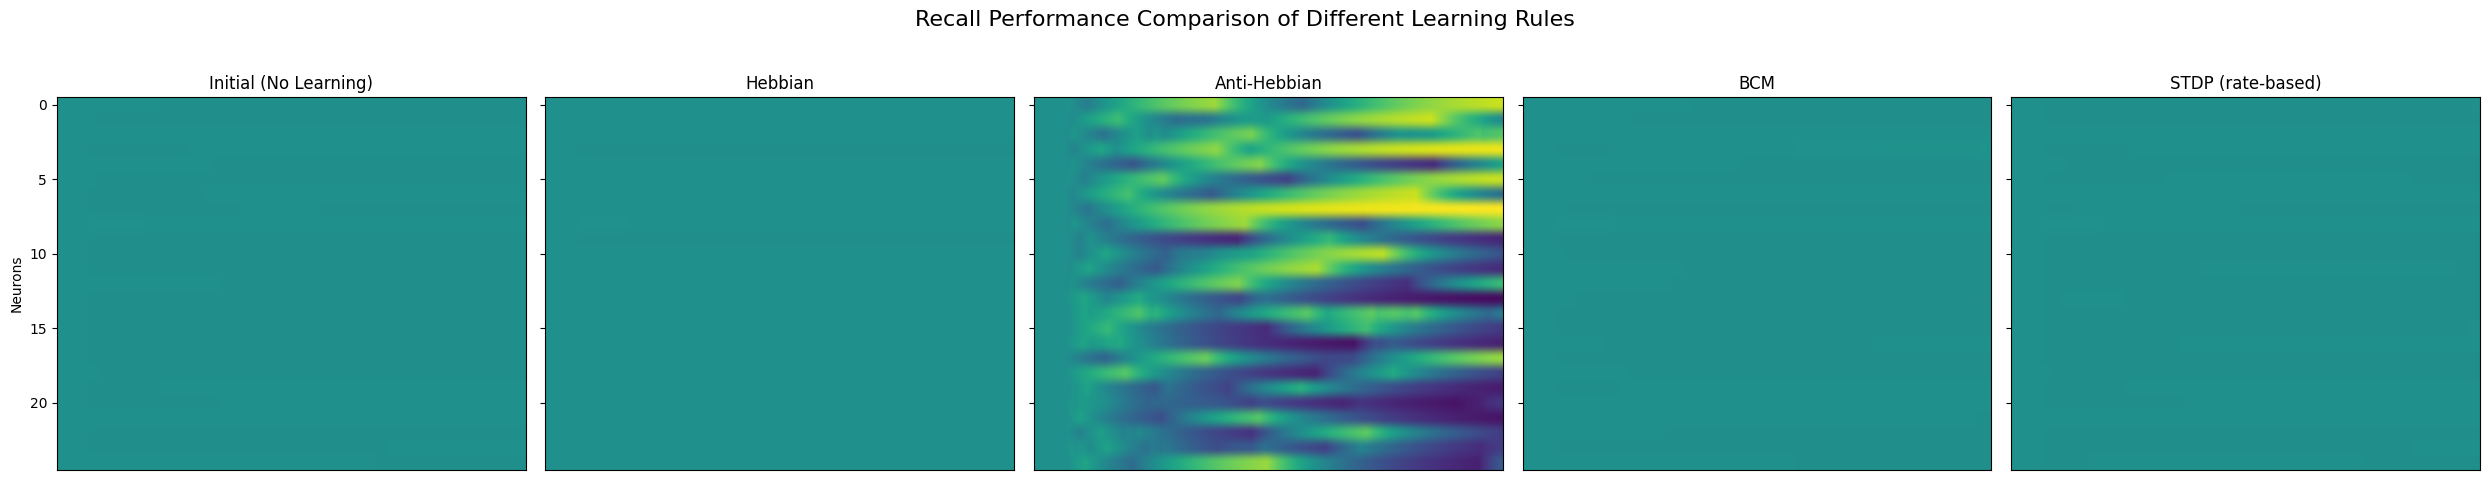

In [ ]:
input_stream = generate_sequence_input(model['nIn'], n_timesteps, [0, 1], model['dt'])


def run_learning_simulation(J0, rule_type='hebbian'):
    J = J0.copy()
    firing_rates = np.zeros((model['N'], n_timesteps))
    firing_rates[:, 0] = np.random.uniform(0, 0.1, size=(model['N']))

    # Parameters for rules
    if rule_type == 'bcm':
        theta = np.zeros(model['N']) # BCM threshold
        lr = 0.02
    elif rule_type == 'stdp':
        lr_ltp = 0.01  # Learning rate for potentiation
        lr_ltd = 0.012 # Learning rate for depression
        tau_trace = 200.0 # Time constant for synaptic traces in ms
        pre_trace = np.zeros(model['N'])
        post_trace = np.zeros(model['N'])
    else: # hebbian or anti-hebbian
        lr = 0.005

    print(f"Starting training with {rule_type.upper()} rule...")
    for t in range(n_timesteps - 1):
        r_current = firing_rates[:, t]
        I_synaptic = J @ r_current
        I_input = Jin @ input_stream[:, t]
        total_input = I_synaptic + I_input
        r_new = r_current + (model['dt'] / model['tau']) * (-r_current + model['nonlin'](total_input))
        firing_rates[:, t+1] = np.clip(r_new, -1.0, 1.0)

        if rule_type == 'hebbian':
            update = np.outer(firing_rates[:, t+1], r_current)
            J += lr * update - (lr * 0.1) * J

        elif rule_type == 'anti-hebbian':
            update = np.outer(firing_rates[:, t+1], r_current)
            J -= lr * update - (lr * 0.1) * J

        elif rule_type == 'bcm':
            r_post = firing_rates[:, t+1]
            phi = r_post * (r_post - theta)
            update = np.outer(phi, r_current)
            J += lr * update
            theta += (model['dt'] / 200.0) * (-theta + r_post**2)

        elif rule_type == 'stdp':
            r_pre = firing_rates[:, t]
            r_post = firing_rates[:, t+1]

            # Update synaptic traces
            pre_trace += (model['dt'] / tau_trace) * (-pre_trace + r_pre)
            post_trace += (model['dt'] / tau_trace) * (-post_trace + r_post)

            # Calculate potentiation (LTP) and depression (LTD)
            LTP = lr_ltp * np.outer(r_post, pre_trace)
            LTD = lr_ltd * np.outer(post_trace, r_pre)

            # Apply the update
            J += LTP - LTD

    print("Training finished.")
    return J

J_hebbian = run_learning_simulation(J_initial, 'hebbian')
J_anti_hebbian = run_learning_simulation(J_initial, 'anti-hebbian')
J_bcm = run_learning_simulation(J_initial, 'bcm')
J_stdp = run_learning_simulation(J_initial, 'stdp')

def run_recall_test(J_matrix):
    test_time = 1500.0
    n_test_timesteps = int(test_time / model['dt'])
    weak_cue_stream = np.zeros((model['nIn'], n_test_timesteps))
    cue_start_idx = int(100 / model['dt'])
    cue_end_idx = int(120 / model['dt'])
    weak_cue_stream[stimulus_id, cue_start_idx:cue_end_idx] = 0.2

    rates = np.zeros((model['N'], n_test_timesteps))
    for t in range(n_test_timesteps - 1):
        r_current = rates[:, t]
        I_synaptic = J_matrix @ r_current
        I_input = Jin @ weak_cue_stream[:, t]
        total_input = I_synaptic + I_input
        r_new = r_current + (model['dt'] / model['tau']) * (-r_current + model['nonlin'](total_input))
        rates[:, t+1] = np.clip(r_new, -1.0, 1.0)
    return rates

print("\nRunning recall tests...")
recall_initial = run_recall_test(J_initial)
recall_hebbian = run_recall_test(J_hebbian)
recall_anti_hebbian = run_recall_test(J_anti_hebbian)
recall_bcm = run_recall_test(J_bcm)
recall_stdp = run_recall_test(J_stdp)

fig, axes = plt.subplots(1, 5, figsize=(25, 5), sharey=True)
fig.suptitle("Recall Performance Comparison of Different Learning Rules", fontsize=16)

scenarios = {
    "Initial (No Learning)": recall_initial,
    "Hebbian": recall_hebbian,
    "Anti-Hebbian": recall_anti_hebbian,
    "BCM": recall_bcm,
    "STDP (rate-based)": recall_stdp
}

for i, (title, data) in enumerate(scenarios.items()):
    ax = axes[i]
    im = ax.imshow(data, aspect='auto', vmin=-1, vmax=1, cmap='viridis')
    ax.set_title(title)
    ax.set_xticks([])
    if i == 0:
        ax.set_ylabel("Neurons")

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

- how big the right hand term is
- too much weight isn't realistic (inputs in the same order of magnitude)

give constant 1 as input (done)

analyse clipping effect (done)

store more than 1 memory state

< 100 neurons means finite size effect (done)

scale weights/numbers to 'mean' sth (other than [-1, 1])

"low-rank" matrix & analysis?

extra stuff:

- compute angle between learned patterns

- inject stimulus to jump between memory states

1 non-specified group of neurons (n + 1 total groups)

stable manifold prevents moving between states

bifurcation -> removes manifold -> jumping between states

In [ ]:
model = {}

# Model parameters
# model['N_e'] = 80         # Number of excitatory neurons
# model['N_i'] = 20         # Number of inhibitory neurons
# model['N'] = model['N_e'] + model['N_i'] # Total neurons
model['N'] = 20

model['g'] = 0.95         # gain of synaptic weights
model['sp'] = 0.25        # sparsity of the weight matrix
model['tau'] = 30.0       # membrane time constant in ms
model['dt'] = 0.1         # simulation timestep in ms
model['nonlin'] = lambda x: np.tanh(x) # sigmoidal transfer function

# Input properties
model['nIn'] = 5          # number of possible input stimuli
model['gIn'] = 0.6        # gain of the input weights
model['spIn'] = 0.07      # sparsity of the input weights

# Hebbian Learning Parameters
model['learning_rate'] = 5e-4 # Controls how fast the weights change
# model['weight_decay'] = 1e-4  # Prevents weights from growing infinitely

model['tau_avg'] = 200.0

# model['learning_rate_e'] = 1e-3 # E-E learning rate
# model['learning_rate_i'] = 5e-4 # Learning rate for inhibitory plasticity
# model['weight_decay'] = 1e-4  # Adjusted weight decay

# model['homeostatic_sum'] = 1.44 # Target sum for incoming E-E weights


# model['bcm_lr'] = 1e-2
# model['tau_theta'] = 300.0

In [ ]:
# -------------------------------------------- ONLY RUN ONCE ------------------------------------
# initial random recurrent weight matrix J
randMat = np.random.normal(0, 1, size=(model['N'], model['N']))
spMat = np.random.uniform(0, 1, size=(model['N'], model['N'])) <= model['sp']
J = np.multiply(randMat, spMat) * model['g'] / math.sqrt(model['N'] * model['sp'])

# ---------------------------------- le new ------------------------------
# J[:, :model['N_e']] = np.abs(J[:, :model['N_e']])
# J[:, model['N_e']:] = -np.abs(J[:, model['N_e']:])
# # ------------------------------------------------------------------------

# np.fill_diagonal(J, 0)
J_initial = J.copy() # copy for later comparison

# fixed input weight matrix Jin              (SHOULD NOT BE RANDOM ?)
# randMatIn = np.random.normal(0, 1, size=(model['N'], model['nIn']))
# spMatIn = np.random.uniform(0, 1, size=(model['N'], model['nIn'])) <= model['spIn']
# Jin = np.multiply(randMatIn, spMatIn) * model['gIn'] / math.sqrt(model['nIn'] * model['spIn'])

# -------------------------- le old --------------------------------------
spMatIn = np.random.uniform(0, 1, size=(model['N'], model['nIn'])) <= model['spIn']
Jin = spMatIn.astype(float) * 1.0 * model['gIn'] / math.sqrt(model['nIn'] * model['spIn'])
# ------------------------------------------------------------------------

# --------------------------- le new --------------------------------------
# spMatIn = np.random.uniform(0, 1, size=(model['N_e'], model['nIn'])) <= model['spIn']
# Jin = np.zeros((model['N'], model['nIn']))
# Jin[:model['N_e'], :] = spMatIn.astype(float) * 1.0 * model['gIn'] / math.sqrt(model['nIn'] * model['spIn'])
# -------------------------------------------------------------------------

In [ ]:
# J = np.zeros((model['N'], model['N']))
# # random connections for each sub-population
# J_ee_rand = np.random.normal(0, 1, size=(model['N_e'], model['N_e']))
# J_ei_rand = np.random.normal(0, 1, size=(model['N_e'], model['N_i']))
# J_ie_rand = np.random.normal(0, 1, size=(model['N_i'], model['N_e']))
# J_ii_rand = np.random.normal(0, 1, size=(model['N_i'], model['N_i']))

# # sparsity and scale weights (-1, 1)
# J[:model['N_e'], :model['N_e']] = np.multiply(J_ee_rand, np.random.uniform(0, 1, size=(model['N_e'], model['N_e'])) <= model['sp']) * model['g'] / math.sqrt(model['N_e'] * model['sp'])
# J[:model['N_e'], model['N_e']:] = np.multiply(J_ei_rand, np.random.uniform(0, 1, size=(model['N_e'], model['N_i'])) <= model['sp']) * model['g'] / math.sqrt(model['N_i'] * model['sp'])
# J[model['N_e']:, :model['N_e']] = np.multiply(J_ie_rand, np.random.uniform(0, 1, size=(model['N_i'], model['N_e'])) <= model['sp']) * model['g'] / math.sqrt(model['N_e'] * model['sp'])
# J[model['N_e']:, model['N_e']:] = np.multiply(J_ii_rand, np.random.uniform(0, 1, size=(model['N_i'], model['N_i'])) <= model['sp']) * model['g'] / math.sqrt(model['N_i'] * model['sp'])

# # Dale's Law: E neurons have positive weights, I neurons have negative
# J[:, :model['N_e']] = np.abs(J[:, :model['N_e']])
# J[:, model['N_e']:] = -np.abs(J[:, model['N_e']:])

# J_initial = J.copy()

# # Input weight matrix (inputs only on excitatory neurons)
# spMatIn = np.random.uniform(0, 1, size=(model['N_e'], model['nIn'])) <= model['spIn']
# Jin = np.zeros((model['N'], model['nIn']))
# Jin[:model['N_e'], :] = spMatIn.astype(float) * 1.0 * model['gIn'] / math.sqrt(model['nIn'] * model['spIn'])

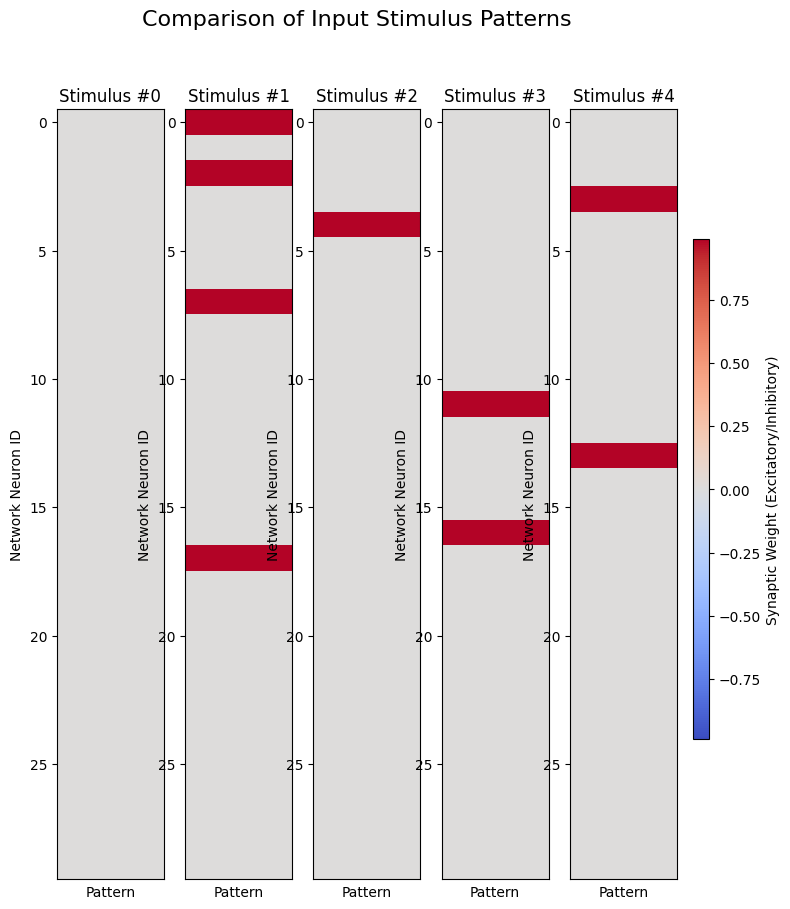

In [ ]:
stimuli_to_visualize = [0, 1, 2, 3, 4]

fig, axes = plt.subplots(1, len(stimuli_to_visualize), figsize=(8, 10))
fig.suptitle('Comparison of Input Stimulus Patterns', fontsize=16)

vmax = np.max(np.abs(Jin))

for i, stim_id in enumerate(stimuli_to_visualize):
    # Get the connection weights for this stimulus (one column from Jin)
    pattern = Jin[:, stim_id]

    # Reshape the 1D array into a 2D column vector for imshow
    pattern_reshaped = pattern.reshape(model['N'], 1)

    # Plot the pattern as a heatmap
    ax = axes[i]
    im = ax.imshow(pattern_reshaped, cmap='coolwarm', aspect='auto', vmin=-vmax, vmax=vmax)

    ax.set_title(f"Stimulus #{stim_id}")
    ax.set_ylabel("Network Neuron ID")
    ax.set_xlabel("Pattern")
    ax.set_xticks([]) # Hide x-axis ticks for clarity

# Add a single, shared colorbar for the entire figure
cbar_ax = fig.add_axes([0.92, 0.25, 0.02, 0.5]) # [left, bottom, width, height]
fig.colorbar(im, cax=cbar_ax, label="Synaptic Weight (Excitatory/Inhibitory)")

plt.show()

In [ ]:
simulation_time = 15000.0 # Total simulation time in ms
n_timesteps = int(simulation_time / model['dt'])


stimulus_id = 0

# input stream with repeated pulses
input_stream = np.zeros((model['nIn'], n_timesteps))
current_time = 100.0
while current_time < simulation_time:
    start_idx = int(current_time / model['dt'])
    end_idx = int((current_time + 50.0) / model['dt']) # duration
    input_stream[stimulus_id, start_idx:end_idx] = 1.0
    current_time += 400.0 # interval


# experiment_repeats = 100
# stimulus_history = []
# for _ in range(experiment_repeats):
#   stimulus_history.extend(np.random.permutation(model['nIn']))

# input_stream = np.zeros((model['nIn'], n_timesteps))
# duration = 50.0
# interval = 250.0
# current_time = 100.0

# for stim_id in stimulus_history:
#   start_idx = int(current_time / model['dt'])
#   end_idx = int((current_time + duration) / model['dt'])
#   if end_idx >= n_timesteps:
#         break
#   input_stream[stim_id, start_idx:end_idx] = 1.0
#   current_time += interval

In [ ]:
# --------------------------------------- ONLY RUN THIS CELL ONCE --------------------------------------
firing_rates = np.zeros((model['N'], n_timesteps))
firing_rates[:, 0] = np.random.uniform(0, 0.1, size=(model['N']))

# theta = np.zeros(model['N_e']) # for BCM

In [ ]:
# ------------------------------------------ Hebbian learning SIMPLE ---------------------------------------------
# for t in range(n_timesteps - 1):
#     r_current = firing_rates[:, t]

#     # update firing rates
#     I_synaptic = J @ r_current
#     I_input = Jin @ input_stream[:, t]
#     total_input = I_synaptic + I_input
#     r_new = r_current + (model['dt'] / model['tau']) * (-r_current + model['nonlin'](total_input))
#     firing_rates[:, t+1] = np.clip(r_new, -1.0, 1.0)

#     # --- HEBBIAN LEARNING UPDATE ---
#     hebbian_update = np.outer(firing_rates[:, t+1], r_current)
#     delta_J = model['learning_rate'] * hebbian_update - model['weight_decay'] * J
#     J += delta_J

# J_learned = J.copy()


# ----------------------------------------- Hebbian Learning DALE E, I PLASTICITY -----------------------------
# avg_e_rate = np.zeros(model['N_e']) # Keep running average of E-neuron rates

# for t in range(n_timesteps - 1):
#     r_current = firing_rates[:, t]
#     I_synaptic = J @ r_current
#     I_input = Jin @ input_stream[:, t]
#     total_input = I_synaptic + I_input
#     r_new = r_current + (model['dt'] / model['tau']) * (-r_current + model['nonlin'](total_input))
#     firing_rates[:, t+1] = np.clip(r_new, -1.0, 1.0)

#     # ---------------- COMPETITIVE HEBBIAN LEARNING UPDATE (E->E) ---------------
#     # update weights for E-neurons firing above their average (heterosynaptic plasticity)
#     r_e_current = firing_rates[:model['N_e'], t]
#     r_e_new = firing_rates[:model['N_e'], t+1]

#     # update running average
#     avg_e_rate = 0.999 * avg_e_rate + 0.001 * r_e_new

#     # only neurons firing above average contribute to potentiation
#     post_activity = np.maximum(0, r_e_new - avg_e_rate)

#     hebbian_update = np.outer(post_activity, r_e_current)

#     # apply plasticity to E-E connections
#     delta_J_ee = model['learning_rate_e'] * hebbian_update - model['weight_decay'] * J[:model['N_e'], :model['N_e']]
#     J[:model['N_e'], :model['N_e']] += delta_J_ee

#     # -------------------- INHIBITORY PLASTICITY (I->E) -------------------------
#     # strengthens inhibition onto active E-neurons
#     r_i_current = firing_rates[model['N_e']:, t]
#     hebbian_update_ei = np.outer(r_e_new, r_i_current)
#     delta_J_ei = model['learning_rate_i'] * hebbian_update_ei
#     J[:model['N_e'], model['N_e']:] -= delta_J_ei

#     # ----------------- Clip weights to enforce Dale's Law ---------------------
#     J[:, :model['N_e']] = np.maximum(0, J[:, :model['N_e']])
#     J[:, model['N_e']:] = np.minimum(0, J[:, model['N_e']:])

# J_learned = J.copy()


# ---------------------------------------- Hebbian Learning HOMEOSTATIC ----------------------------------
# for t in range(n_timesteps - 1):
#     r_current = firing_rates[:, t]

#     # update firing rates
#     I_synaptic = J @ r_current
#     I_input = Jin @ input_stream[:, t]
#     total_input = I_synaptic + I_input
#     r_new = r_current + (model['dt'] / model['tau']) * (-r_current + model['nonlin'](total_input))
#     firing_rates[:, t+1] = np.clip(r_new, -1.0, 1.0)

#     # Hebbian update on E->E
#     r_e_current = firing_rates[:model['N_e'], t]
#     r_e_new = firing_rates[:model['N_e'], t+1]
#     hebbian_update_ee = np.outer(r_e_new, r_e_current)
#     delta_J_ee = model['learning_rate_e'] * hebbian_update_ee - model['weight_decay'] * J[:model['N_e'], :model['N_e']]
#     J[:model['N_e'], :model['N_e']] += delta_J_ee

#     # Hebbian update on E->I
#     r_i_current = firing_rates[model['N_e']:, t]
#     hebbian_update_ei = np.outer(r_e_new, r_i_current)
#     delta_J_ei = model['learning_rate_i'] * hebbian_update_ei
#     J[:model['N_e'], model['N_e']:] -= delta_J_ei

#     # Homeostatic constraint (renormalising E weights on E postsynaptic neurons)
#     epsilon = 1e-6
#     current_sums = np.sum(J[:model['N_e'], :model['N_e']], axis=1)
#     scaling_factor = model['homeostatic_sum'] / (current_sums + epsilon)
#     J[:model['N_e'], :model['N_e']] *= scaling_factor.reshape(-1, 1)

#     J[:, :model['N_e']] = np.maximum(0, J[:, :model['N_e']])
#     J[:, model['N_e']:] = np.maximum(0, J[:, model['N_e']:])

# J_learned = J.copy()


# --------------------------------------- BCM Learning -----------------------------------------
# for t in range(n_timesteps - 1):
#     r_current = firing_rates[:, t]

#     # update firing rates
#     I_synaptic = J @ r_current
#     I_input = Jin @ input_stream[:, t]
#     total_input = I_synaptic + I_input
#     r_new = r_current + (model['dt'] / model['tau']) * (-r_current + model['nonlin'](total_input))
#     firing_rates[:, t+1] = np.clip(r_new, -1.0, 1.0)

#     r_e_current = firing_rates[:model['N_e'], t]
#     r_e_new = firing_rates[:model['N_e'], t+1]

#     phi = r_e_new * (r_e_new - theta)

#     delta_J = model['bcm_lr'] * np.outer(phi, r_e_current)
#     J[:model['N_e'], :model['N_e']] += delta_J

#     delta_theta = (model['dt'] / model['tau_theta']) * (-theta + r_e_new**2)
#     theta += delta_theta

#     J[:, :model['N_e']] = np.maximum(0, J[:, :model['N_e']])

# J_learned = J.copy()


# ---------------------------------- Hebbian Learning HOPFIELD -----------------------------
avg_rate = np.zeros(model['N']) # running average of each neuron's rate
for t in range(n_timesteps - 1):

    r_current = firing_rates[:, t]
    I_synaptic = J @ r_current
    I_input = Jin @ input_stream[:, t]
    total_input = I_synaptic + I_input
    r_new = r_current + (model['dt'] / model['tau']) * (-r_current + model['nonlin'](total_input))
    firing_rates[:, t+1] = np.clip(r_new, -1.0, 1.0)

    # Covariance Learning Update
    # Update the running average of firing rates
    avg_rate += (model['dt'] / model['tau_avg']) * (r_current - avg_rate)

    # deviation from the mean for pre- and post-synaptic neurons
    pre_dev = r_current - avg_rate
    post_dev = firing_rates[:, t+1] - avg_rate

    delta_J = model['learning_rate'] * np.outer(post_dev, pre_dev)
    J += delta_J

J_learned = J.copy()

In [ ]:
fig = plt.figure(figsize=(15, 12))
gs = fig.add_gridspec(3, 2)
timesteps_array = np.arange(n_timesteps) * model['dt']

# Plot a sample of the complex input stream
ax0 = fig.add_subplot(gs[0, :])
ax0.imshow(input_stream[:, :int(simulation_time/model['dt'])], aspect='auto', extent=[0, int(simulation_time), model['nIn'], 0], cmap='Greys')
ax0.set_title("Input Stream Sample")
ax0.set_xlabel("Time (ms)")
ax0.set_ylabel("Stimulus ID")

# Plot firing rates heatmap
ax1 = fig.add_subplot(gs[1, :])
im1 = ax1.imshow(firing_rates, aspect='auto', extent=[0, simulation_time, model['N'], 0])
ax1.set_title(f"Firing Rates of {model['N']} Neurons During Learning")
ax1.set_xlabel("Time (ms)")
ax1.set_ylabel("Neuron ID")
fig.colorbar(im1, ax=ax1, label="Firing Rate")


# ax_line = fig.add_subplot(gs[2, :])
# # Find the N neurons most strongly connected to the input stimulus
# n_to_plot = 10
# top_neurons = np.argsort(Jin[:, stimulus_id])[-n_to_plot:]
# for i, neuron_idx in enumerate(top_neurons):
#     ax_line.plot(timesteps_array, firing_rates[neuron_idx, :], label=f'Neuron #{neuron_idx}')

# ax_line.set_title("Firing Rates of Select Neurons")
# ax_line.set_xlabel("Time (ms)")
# ax_line.set_ylabel("Firing Rate")
# ax_line.legend()
# ax_line.grid(True)


# Compare J matrix before and after learning
ax2 = fig.add_subplot(gs[2, 0])
vmax = np.max(np.abs(J_initial))
im2 = ax2.imshow(J_initial, cmap='coolwarm', vmin=-vmax, vmax=vmax)
ax2.set_title("Initial Random J Matrix")
ax2.set_xlabel("Presynaptic Neuron")
ax2.set_ylabel("Postsynaptic Neuron")
fig.colorbar(im2, ax=ax2, label="Synaptic Weight")

ax3 = fig.add_subplot(gs[2, 1])
vmax = np.max(np.abs(J_learned))
im3 = ax3.imshow(J_learned, cmap='coolwarm', vmin=-vmax, vmax=vmax)
ax3.set_title("Final 'Learned' J Matrix")
ax3.set_xlabel("Presynaptic Neuron")
fig.colorbar(im3, ax=ax3, label="Synaptic Weight")

plt.tight_layout()
plt.show()

NameError: name 'firing_rates' is not defined

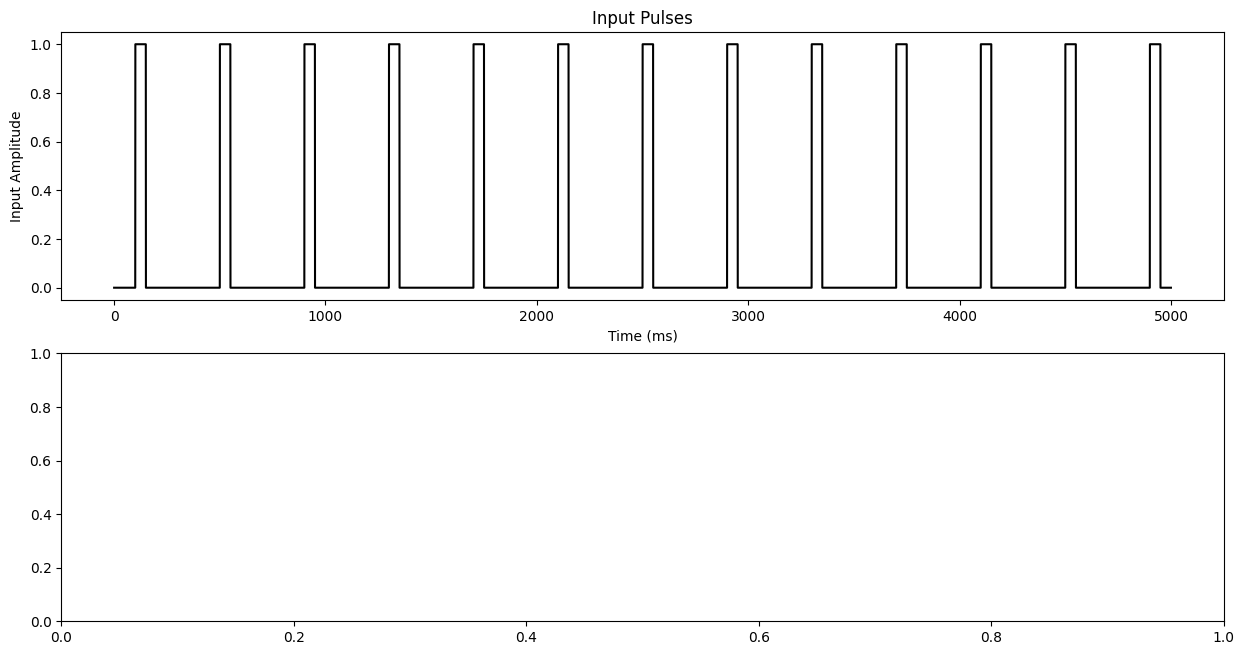

In [ ]:
# Visualization of Results
fig = plt.figure(figsize=(15, 16))
gs = fig.add_gridspec(4, 2) # Increased grid size for the new plot
timesteps_array = np.arange(n_timesteps) * model['dt']

# Plot input and firing rates heatmap (same as before)
ax0 = fig.add_subplot(gs[0, :])
ax0.plot(timesteps_array, input_stream[0, :], 'k')
ax0.set_title(f"Input Pulses")
ax0.set_xlabel("Time (ms)")
ax0.set_ylabel("Input Amplitude")

ax1 = fig.add_subplot(gs[1, :])
im = ax1.imshow(firing_rates, aspect='auto', extent=[0, simulation_time, model['N'], 0])
ax1.set_title(f"Firing Rates Heatmap of {model['N']} Neurons")
ax1.set_xlabel("Time (ms)")
ax1.set_ylabel("Neuron ID")
fig.colorbar(im, ax=ax1, label="Firing Rate")

# --- NEW: Line Plot of Select Neuron Firing Rates ---
ax_line = fig.add_subplot(gs[2, :])
# Find the N neurons most strongly connected to the input stimulus
n_to_plot = 50
top_neurons = np.argsort(Jin[:, 0])[-n_to_plot:]
for i, neuron_idx in enumerate(top_neurons):
    ax_line.plot(timesteps_array, firing_rates[neuron_idx, :], label=f'Neuron #{neuron_idx}')

ax_line.set_title("Firing Rates of Select Neurons")
ax_line.set_xlabel("Time (ms)")
ax_line.set_ylabel("Firing Rate")
ax_line.legend()
ax_line.grid(True)

# Compare J matrix before and after learning
ax2 = fig.add_subplot(gs[3, 0])
vmax = np.max(np.abs(J_initial))
im2 = ax2.imshow(J_initial, cmap='coolwarm', vmin=-vmax, vmax=vmax)
ax2.set_title("Initial Random J Matrix")
ax2.set_xlabel("Presynaptic Neuron")
ax2.set_ylabel("Postsynaptic Neuron")
fig.colorbar(im2, ax=ax2, label="Synaptic Weight")

ax3 = fig.add_subplot(gs[3, 1])
vmax = np.max(np.abs(J))
im3 = ax3.imshow(J, cmap='coolwarm', vmin=-vmax, vmax=vmax)
ax3.set_title("Final 'Learned' J Matrix")
ax3.set_xlabel("Presynaptic Neuron")
fig.colorbar(im3, ax=ax3, label="Synaptic Weight")

plt.tight_layout()
plt.show()

In [ ]:
import networkx as nx
from matplotlib.lines import Line2D

def visualize_network_subset(ax, J_matrix, N_subset=25, title=""):
    """
    Visualizes a subset of the neural network connectivity using networkx.

    Args:
        ax (matplotlib.axes.Axes): The matplotlib axes to plot on.
        J_matrix (np.ndarray): The full N x N synaptic weight matrix.
        N_subset (int): The number of neurons to include in the visualization.
        title (str): The title for the subplot.
    """
    # Create a directed graph
    G = nx.DiGraph()

    # Get a subset of the matrix
    J_subset = J_matrix[:N_subset, :N_subset]

    # Add nodes
    for i in range(N_subset):
        G.add_node(i)

    # Add edges with weights and colors
    edges = []
    weights = []
    colors = []
    max_abs_weight = np.max(np.abs(J_subset))

    for i in range(N_subset):
        for j in range(N_subset):
            weight = J_subset[i, j]
            if weight != 0: # Only add an edge if a connection exists
                G.add_edge(j, i, weight=weight) # j -> i
                colors.append('#d6604d' if weight > 0 else '#4393c3') # Red=Excitatory, Blue=Inhibitory
                # Normalize weight for visibility
                weights.append(5 * abs(weight) / max_abs_weight)

    # Use a spring layout for positioning the nodes
    pos = nx.spring_layout(G, seed=42)

    # Draw the network
    nx.draw_networkx_nodes(G, pos, ax=ax, node_color='#666', node_size=200)
    nx.draw_networkx_edges(G, pos, ax=ax, edge_color=colors, width=weights, alpha=0.7, arrows=False)
    nx.draw_networkx_labels(G, pos, ax=ax, font_size=8, font_color='white')

    ax.set_title(title)
    ax.axis('off')

    legend_elements = [
        Line2D([0], [0], color='#d6604d', lw=4, label='Excitatory (+)'),
        Line2D([0], [0], color='#4393c3', lw=4, label='Inhibitory (-)')
    ]
    ax.legend(handles=legend_elements, loc='upper right')

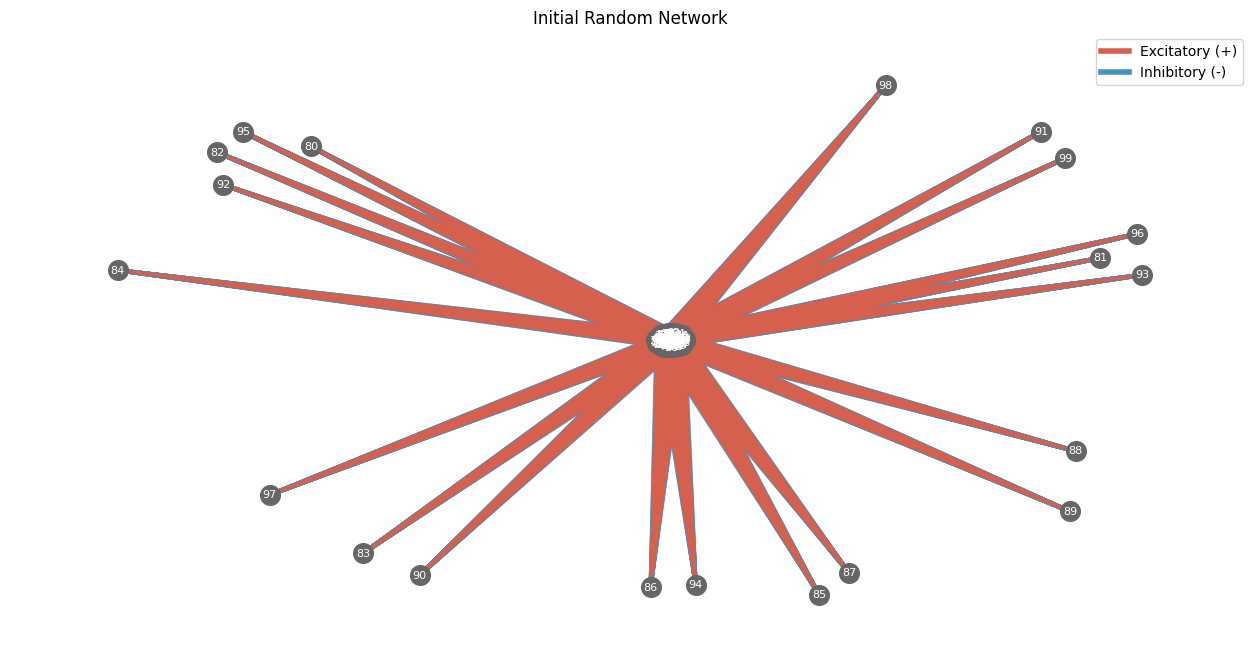

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(16, 8))

visualize_network_subset(ax, J_initial, N_subset=100, title="Initial Random Network")

plt.show()

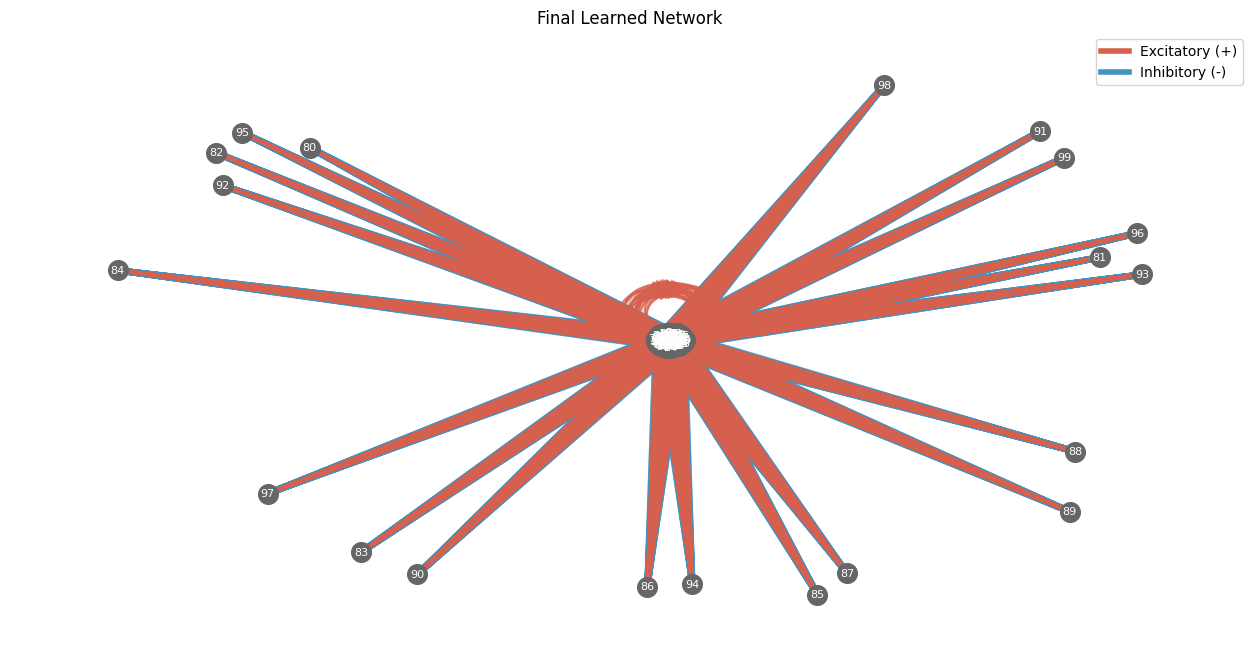

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(16, 8))

visualize_network_subset(ax, J_learned, N_subset=100, title="Final Learned Network")

plt.show()

# DIFFERENT "GROUPS" DEFINE THE LEARNING BENCHMARK ???


Running comprehensive recall test on the learned network...


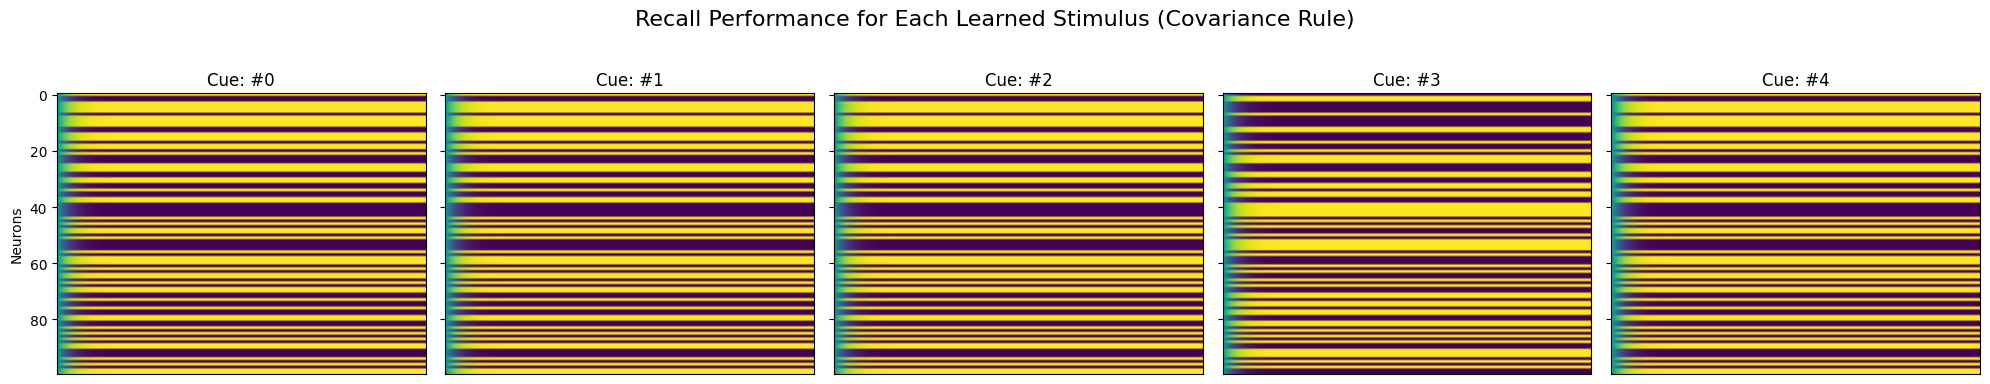

In [ ]:
def run_recall_test(J_matrix, stim_id_to_test):
    test_time = 1000.0
    n_test_timesteps = int(test_time / model['dt'])

    weak_cue_stream = np.zeros((model['nIn'], n_test_timesteps))
    cue_start_idx = int(100 / model['dt'])
    cue_end_idx = int(120 / model['dt'])
    weak_cue_stream[stim_id_to_test, cue_start_idx:cue_end_idx] = 0.2

    rates = np.zeros((model['N'], n_test_timesteps))
    rates[:, 0] = np.random.uniform(0, 0.1, size=(model['N']))
    for t in range(n_test_timesteps - 1):
        r_current = rates[:, t]
        I_synaptic = J_matrix @ r_current
        I_input = Jin @ weak_cue_stream[:, t]
        total_input = I_synaptic + I_input
        r_new = r_current + (model['dt'] / model['tau']) * (-r_current + model['nonlin'](total_input))
        rates[:, t+1] = np.clip(r_new, -1.0, 1.0)
    return rates

print("\nRunning comprehensive recall test on the learned network...")

# Create a grid of subplots for visualization
fig, axes = plt.subplots(1, model['nIn'], figsize=(20, 4), sharey=True)
fig.suptitle("Recall Performance for Each Learned Stimulus (Covariance Rule)", fontsize=16)

for stim_id in range(model['nIn']):
    ax = axes[stim_id]
    recall_rates = run_recall_test(J_learned, stim_id)

    im = ax.imshow(recall_rates, aspect='auto', vmin=-1, vmax=1, cmap='viridis')
    ax.set_title(f"Cue: #{stim_id}")
    ax.set_xticks([])
    if stim_id == 0:
        ax.set_ylabel("Neurons")

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [ ]:
# Memory Test
test_time = 1000.0 # ms
n_test_timesteps = int(test_time / model['dt'])
stimulus_id = 0 # The stimulus the network learned

# Weak Input Cue
weak_cue_stream = np.zeros((model['nIn'], n_test_timesteps))
cue_start_idx = int(100 / model['dt'])
cue_end_idx = int(120 / model['dt']) # duration
cue_amplitude = 0.2 # percentage of original strength

weak_cue_stream[stimulus_id, cue_start_idx:cue_end_idx] = cue_amplitude

In [ ]:
# Two Simulations: Before and After Learning
def run_test(J_matrix):
    """Runs a recall test with a given J matrix."""
    rates = np.zeros((model['N'], n_test_timesteps))
    rates[:, 0] = np.random.uniform(0, 0.1, size=(model['N']))

    for t in range(n_test_timesteps - 1):
        r_current = rates[:, t]
        I_synaptic = J_matrix @ r_current
        I_input = Jin @ weak_cue_stream[:, t]
        total_input = I_synaptic + I_input
        r_new = r_current + (model['dt'] / model['tau']) * (-r_current + model['nonlin'](total_input))
        rates[:, t+1] = np.clip(r_new, -1.0, 1.0)
    return rates

print("Running test on the network BEFORE learning...")
rates_before_learning = run_test(J_initial)

print("Running test on the network AFTER learning...")
rates_after_learning = run_test(J)

print("Simulations finished.")

Running test on the network BEFORE learning...
Running test on the network AFTER learning...
Simulations finished.


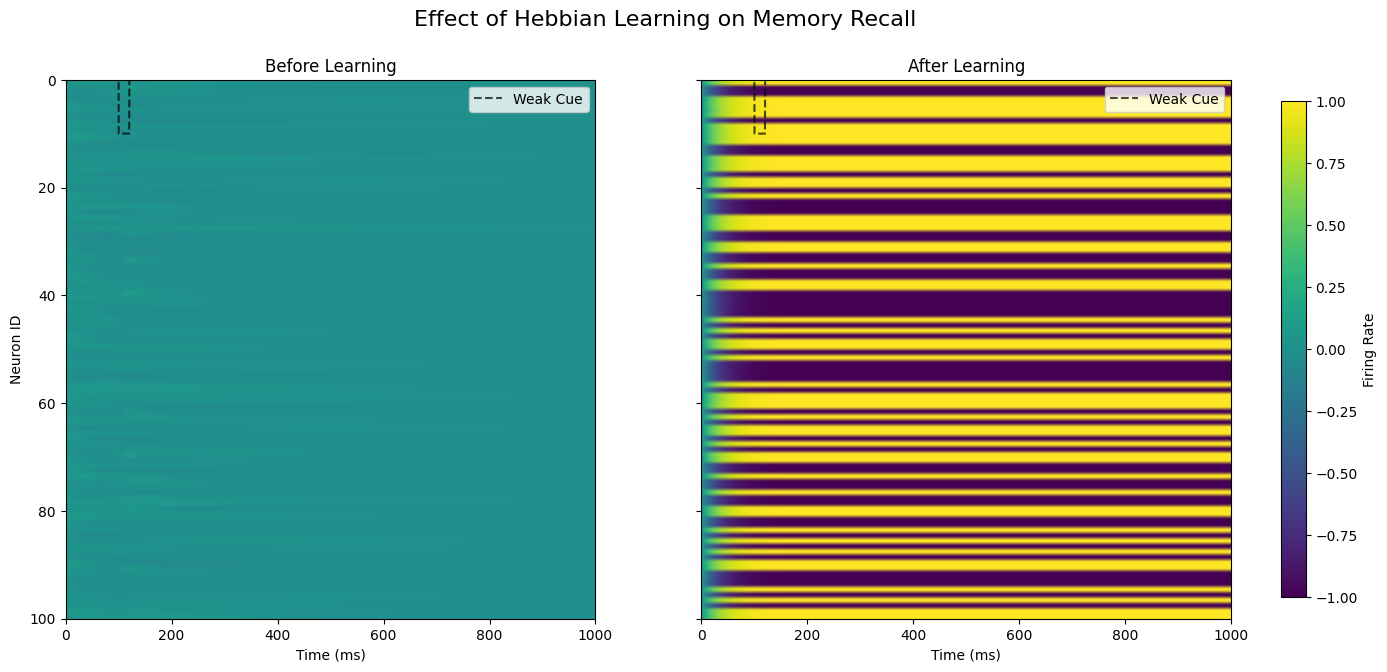

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7), sharey=True)
timesteps_array = np.arange(n_test_timesteps) * model['dt']

# Plot 1: Before Learning
ax1.set_title("Before Learning")
im1 = ax1.imshow(rates_before_learning, aspect='auto', extent=[0, test_time, model['N'], 0], vmin=-1, vmax=1)
ax1.plot(timesteps_array, weak_cue_stream[stimulus_id, :] * model['N'] * 0.5, 'k--', alpha=0.7, label='Weak Cue')
ax1.set_xlabel("Time (ms)")
ax1.set_ylabel("Neuron ID")
ax1.legend()

# Plot 2: After Learning
ax2.set_title("After Learning")
im2 = ax2.imshow(rates_after_learning, aspect='auto', extent=[0, test_time, model['N'], 0], vmin=-1, vmax=1)
ax2.plot(timesteps_array, weak_cue_stream[stimulus_id, :] * model['N'] * 0.5, 'k--', alpha=0.7, label='Weak Cue')
ax2.set_xlabel("Time (ms)")
ax2.legend()

fig.colorbar(im2, ax=[ax1, ax2], orientation='vertical', fraction=0.02, pad=0.04, label="Firing Rate")

plt.suptitle("Effect of Hebbian Learning on Memory Recall", fontsize=16)
plt.show()

low-rank adaptation matrix for phase plane (10x10 matrix -> rank 7 -> 7x7 matrix)

embedded subspace

linear independency & orthogonalisation

base vectors

Gramm-Schmidt method

basically linear algebra stuff

Performing PCA on the firing rate data...
PCA complete. Explained variance by first 2 components: 94.28%


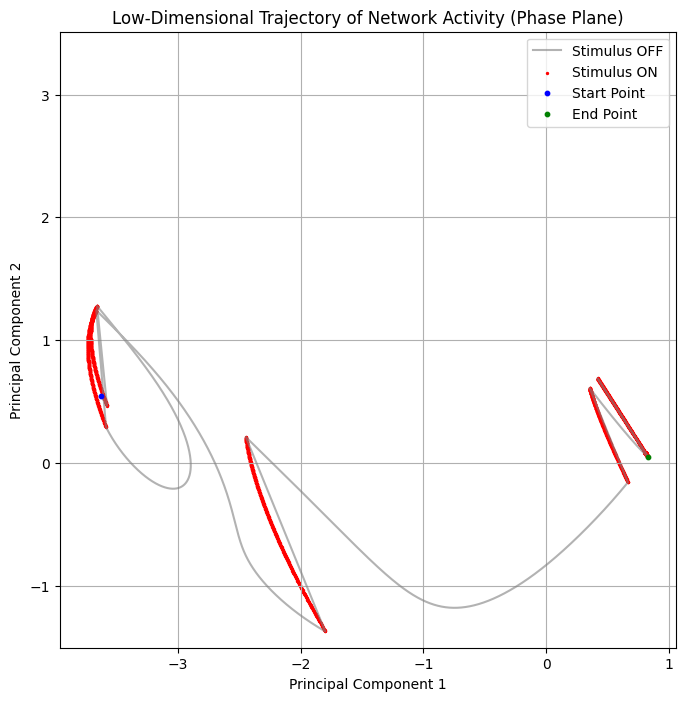

In [ ]:
# PCA and Low-Dimensional Trajectory Plot
from sklearn.decomposition import PCA

print("Performing PCA on the firing rate data...")

# 1. Set up and fit the PCA model
# We want to find the top 2 dimensions that capture the most variance.
pca = PCA(n_components=2)
# scikit-learn expects data as (n_samples, n_features), so we transpose our rates matrix.
rates_pca = pca.fit_transform(firing_rates.T)

print(f"PCA complete. Explained variance by first 2 components: {pca.explained_variance_ratio_.sum()*100:.2f}%")


# 2. Plot the low-dimensional trajectory
plt.figure(figsize=(8, 8))

# We'll color the trajectory based on whether the stimulus is on or off
stimulus_on = input_stream[stimulus_id, :] > 0

# Plot the trajectory during the "stimulus OFF" periods
plt.plot(rates_pca[~stimulus_on, 0], rates_pca[~stimulus_on, 1],
         linestyle='-', color='gray', alpha=0.6, label='Stimulus OFF')

# Plot the trajectory during the "stimulus ON" periods
plt.scatter(rates_pca[stimulus_on, 0], rates_pca[stimulus_on, 1],
            c='red', s=2, label='Stimulus ON')

# Highlight the starting point of the simulation
plt.scatter(rates_pca[0, 0], rates_pca[0, 1],
            c='blue', s=10, marker='o', label='Start Point', zorder=5)

# Highlight the ending point of the simulation
plt.scatter(rates_pca[-1, 0], rates_pca[-1, 1],
            c='green', s=10, marker='o', label='End Point', zorder=5)

plt.title('Low-Dimensional Trajectory of Network Activity (Phase Plane)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.grid(True)
plt.axis('square')
plt.show()

In [ ]:
pca.explained_variance_ratio_

array([0.88872165, 0.05406748])

In [ ]:
pca_3d.explained_variance_ratio_

array([0.88872165, 0.05406748, 0.03560862])

Performing PCA with 3 components...
PCA complete. Explained variance by first 3 components: 97.84%


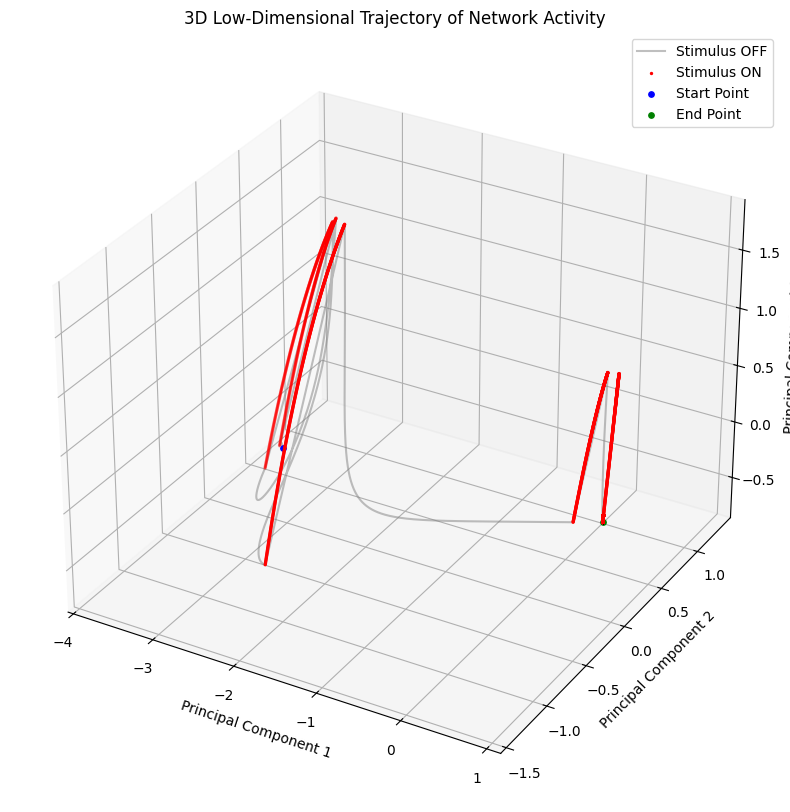

In [ ]:
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D # Required for 3D plotting

print("Performing PCA with 3 components...")

# 1. Set up and fit the PCA model for 3 components
pca_3d = PCA(n_components=3)
# Transpose the rates matrix to have shape (n_samples, n_features)
rates_pca_3d = pca_3d.fit_transform(firing_rates.T)

print(f"PCA complete. Explained variance by first 3 components: {pca_3d.explained_variance_ratio_.sum()*100:.2f}%")

# 2. Plot the 3D low-dimensional trajectory
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

# Color the trajectory based on whether the stimulus is on or off
stimulus_on = input_stream[stimulus_id, :] > 0

# Plot the trajectory during the "stimulus OFF" periods
ax.plot(rates_pca_3d[~stimulus_on, 0],
        rates_pca_3d[~stimulus_on, 1],
        rates_pca_3d[~stimulus_on, 2],
        linestyle='-', color='gray', alpha=0.5, label='Stimulus OFF')

# Plot the trajectory during the "stimulus ON" periods
ax.scatter(rates_pca_3d[stimulus_on, 0],
           rates_pca_3d[stimulus_on, 1],
           rates_pca_3d[stimulus_on, 2],
           c='red', s=2, label='Stimulus ON')

# Highlight the starting point of the simulation
ax.scatter(rates_pca_3d[0, 0], rates_pca_3d[0, 1], rates_pca_3d[0, 2],
           c='blue', s=15, marker='o', label='Start Point', depthshade=False)

# Highlight the ending point of the simulation
ax.scatter(rates_pca_3d[-1, 0], rates_pca_3d[-1, 1], rates_pca_3d[-1, 2],
           c='green', s=15, marker='o', label='End Point', depthshade=False)

ax.set_title('3D Low-Dimensional Trajectory of Network Activity')
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')
ax.legend()
plt.show()

In [ ]:
# DIFFERENT TRAJECTORIES DEFINE LEARNING BENCHMARK ???

In [ ]:
def find_closest_factors(n):
    """Finds two factors of n that are closest to each other."""
    for i in range(int(np.sqrt(n)), 0, -1):
        if n % i == 0:
            return (i, n // i)
    return (1, n) # Fallback for prime numbers

In [ ]:
# A Hopfield network works with binary patterns (+1 and -1).
# We will create 5 distinct, random patterns for the network to store.
N_neurons = 1000  # grid of neurons
n_patterns = 5   # number of memories

rows, cols = find_closest_factors(N_neurons)

patterns = np.zeros((n_patterns, N_neurons))
for i in range(n_patterns):
    patterns[i, :] = np.random.choice([-1, 1], size=N_neurons)

In [ ]:
# Weight Matrix (Hopfield's Rule)
# one-shot "learning" process. The weight matrix is the
# sum of the outer products of all patterns.
J = np.zeros((N_neurons, N_neurons))
for i in range(n_patterns):
    J += np.outer(patterns[i, :], patterns[i, :])

# Normalize by the number of neurons
J /= N_neurons

# Set the diagonal to zero (no self-connections)
np.fill_diagonal(J, 0)

[]

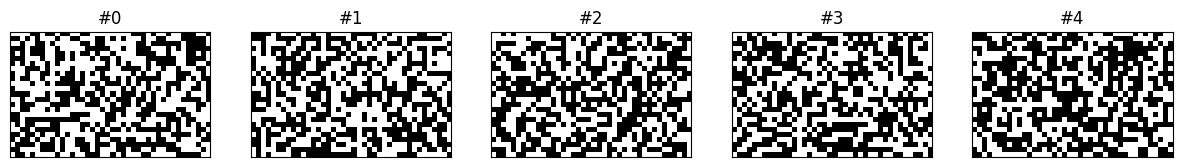

In [ ]:
fig, axes = plt.subplots(1, 5, figsize=(15, 5))

axes[0].imshow(patterns[0, :].reshape(rows, cols), cmap='binary', interpolation='nearest')
axes[0].set_title("#0")
axes[0].set_xticks([])
axes[0].set_yticks([])

axes[1].imshow(patterns[1, :].reshape(rows, cols), cmap='binary', interpolation='nearest')
axes[1].set_title("#1")
axes[1].set_xticks([])
axes[1].set_yticks([])

axes[2].imshow(patterns[2, :].reshape(rows, cols), cmap='binary', interpolation='nearest')
axes[2].set_title("#2")
axes[2].set_xticks([])
axes[2].set_yticks([])

axes[3].imshow(patterns[3, :].reshape(rows, cols), cmap='binary', interpolation='nearest')
axes[3].set_title("#3")
axes[3].set_xticks([])
axes[3].set_yticks([])

axes[4].imshow(patterns[4, :].reshape(rows, cols), cmap='binary', interpolation='nearest')
axes[4].set_title("#4")
axes[4].set_xticks([])
axes[4].set_yticks([])

In [ ]:
# Network Dynamics (Recall Process)
def run_hopfield_recall(initial_state, J_matrix, max_steps=10):
    """
    Takes an initial state and lets the network evolve until it settles.
    """
    current_state = initial_state.copy()
    history = [current_state.copy()]

    for step in range(max_steps):
        # update one neuron at a time
        for _ in range(N_neurons): # full pass over all neurons
            # pick a random neuron to update
            neuron_idx = np.random.randint(0, N_neurons)

            # calculate the input to this neuron
            net_input = J_matrix[neuron_idx, :] @ current_state

            # update neuron's state based on the sign of the input
            current_state[neuron_idx] = 1 if net_input > 0 else -1

        history.append(current_state.copy())

        # check convergence
        if np.array_equal(history[-1], history[-2]):
            print(f"Network converged in {step + 1} steps.")
            break
    else:
        print("Network did not converge within max steps.")

    return history

In [ ]:
pattern_to_recall = patterns[1, :]

# create corrupted version of pattern by flipping some bits
noise_level = 0.2 # flip percent
n_flipped = int(noise_level * N_neurons)
flipped_indices = np.random.choice(N_neurons, size=n_flipped, replace=False)

corrupted_pattern = pattern_to_recall.copy()
corrupted_pattern[flipped_indices] *= -1

# run
recall_history = run_hopfield_recall(corrupted_pattern, J)
recalled_pattern = recall_history[-1]

Network converged in 8 steps.


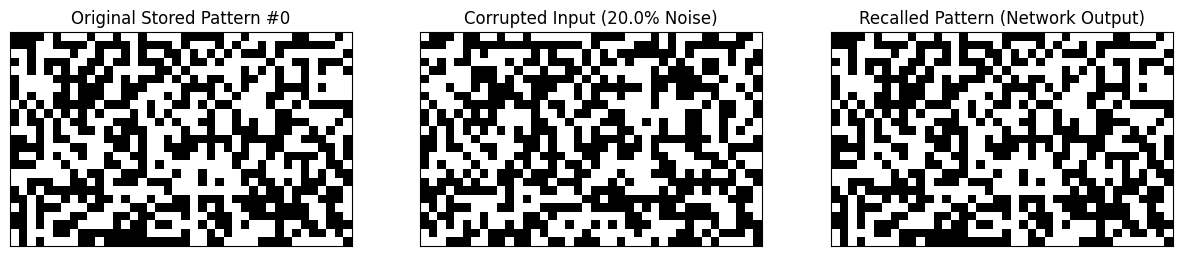


Recall Accuracy: 100.00%


In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].imshow(pattern_to_recall.reshape(rows, cols), cmap='binary', interpolation='nearest')
axes[0].set_title("Original Stored Pattern #0")
axes[0].set_xticks([])
axes[0].set_yticks([])

axes[1].imshow(corrupted_pattern.reshape(rows, cols), cmap='binary', interpolation='nearest')
axes[1].set_title(f"Corrupted Input ({noise_level*100}% Noise)")
axes[1].set_xticks([])
axes[1].set_yticks([])

axes[2].imshow(recalled_pattern.reshape(rows, cols), cmap='binary', interpolation='nearest')
axes[2].set_title("Recalled Pattern (Network Output)")
axes[2].set_xticks([])
axes[2].set_yticks([])

plt.show()

accuracy = np.sum(recalled_pattern == pattern_to_recall) / N_neurons
print(f"\nRecall Accuracy: {accuracy * 100:.2f}%")

In [ ]:
model = {}

model['N'] = 100
model['g'] = 1.0
model['sp'] = 0.25
model['tau'] = 500.0
model['dt'] = 0.1
model['nonlin'] = lambda x: np.tanh(x)
model['nIn'] = 5
model['gIn'] = 2.0
model['spIn'] = 0.2
model['learning_rate'] = 0.01
model['tau_avg'] = 200.0

In [ ]:
randMat = np.random.normal(0, 1, size=(model['N'], model['N']))
spMat = np.random.uniform(0, 1, size=(model['N'], model['N'])) <= model['sp']
J = np.multiply(randMat, spMat) * model['g'] / math.sqrt(model['N'] * model['sp'])

J_initial = J.copy()

spMatIn = np.random.uniform(0, 1, size=(model['N'], model['nIn'])) <= model['spIn']
Jin = spMatIn.astype(float) * 1.0 * model['gIn'] / math.sqrt(model['nIn'] * model['spIn'])

In [ ]:
simulation_time = 20000.0
n_timesteps = int(simulation_time / model['dt'])

pattern_params = {
    0: {'start': 100.0, 'duration': 50.0, 'interval': 300.0, 'amplitude': 2.0},
    1: {'start': 1200.0, 'duration': 70.0, 'interval': 1000.0, 'amplitude': 1.0},
    2: {'start': 800.0, 'duration': 200.0, 'interval': 5000.0, 'amplitude': -1.0},
    3: {'start': 2300.0, 'duration': 100.0, 'interval': 700.0, 'amplitude': 3.0},
    4: {'start': 500.0, 'duration': 10.0, 'interval': 200.0, 'amplitude': -2.0}
}

input_stream = np.zeros((model['nIn'], n_timesteps))

for stim_id, params in pattern_params.items():
    current_time = params['start']
    while current_time < simulation_time:
        start_idx = int(current_time / model['dt'])
        end_idx = int((current_time + params['duration']) / model['dt'])
        if end_idx >= n_timesteps:
            break
        input_stream[stim_id, start_idx:end_idx] = params['amplitude']
        current_time += params['interval']

In [ ]:
firing_rates = np.zeros((model['N'], n_timesteps))
firing_rates[:, 0] = np.random.uniform(0, 0.1, size=(model['N']))

avg_rate = np.zeros(model['N'])

for t in range(n_timesteps - 1):
    r_current = firing_rates[:, t]
    I_synaptic = J @ r_current
    I_input = Jin @ input_stream[:, t]
    total_input = I_synaptic + I_input
    r_new = r_current + (model['dt'] / model['tau']) * (-r_current + model['nonlin'](total_input))
    firing_rates[:, t+1] = np.clip(r_new, -1.0, 1.0)

    # Covariance Learning Update
    avg_rate += (model['dt'] / model['tau_avg']) * (r_current - avg_rate)
    pre_dev = r_current - avg_rate
    post_dev = firing_rates[:, t+1] - avg_rate
    delta_J = model['learning_rate'] * np.outer(post_dev, pre_dev)
    J += delta_J

J_learned = J.copy()

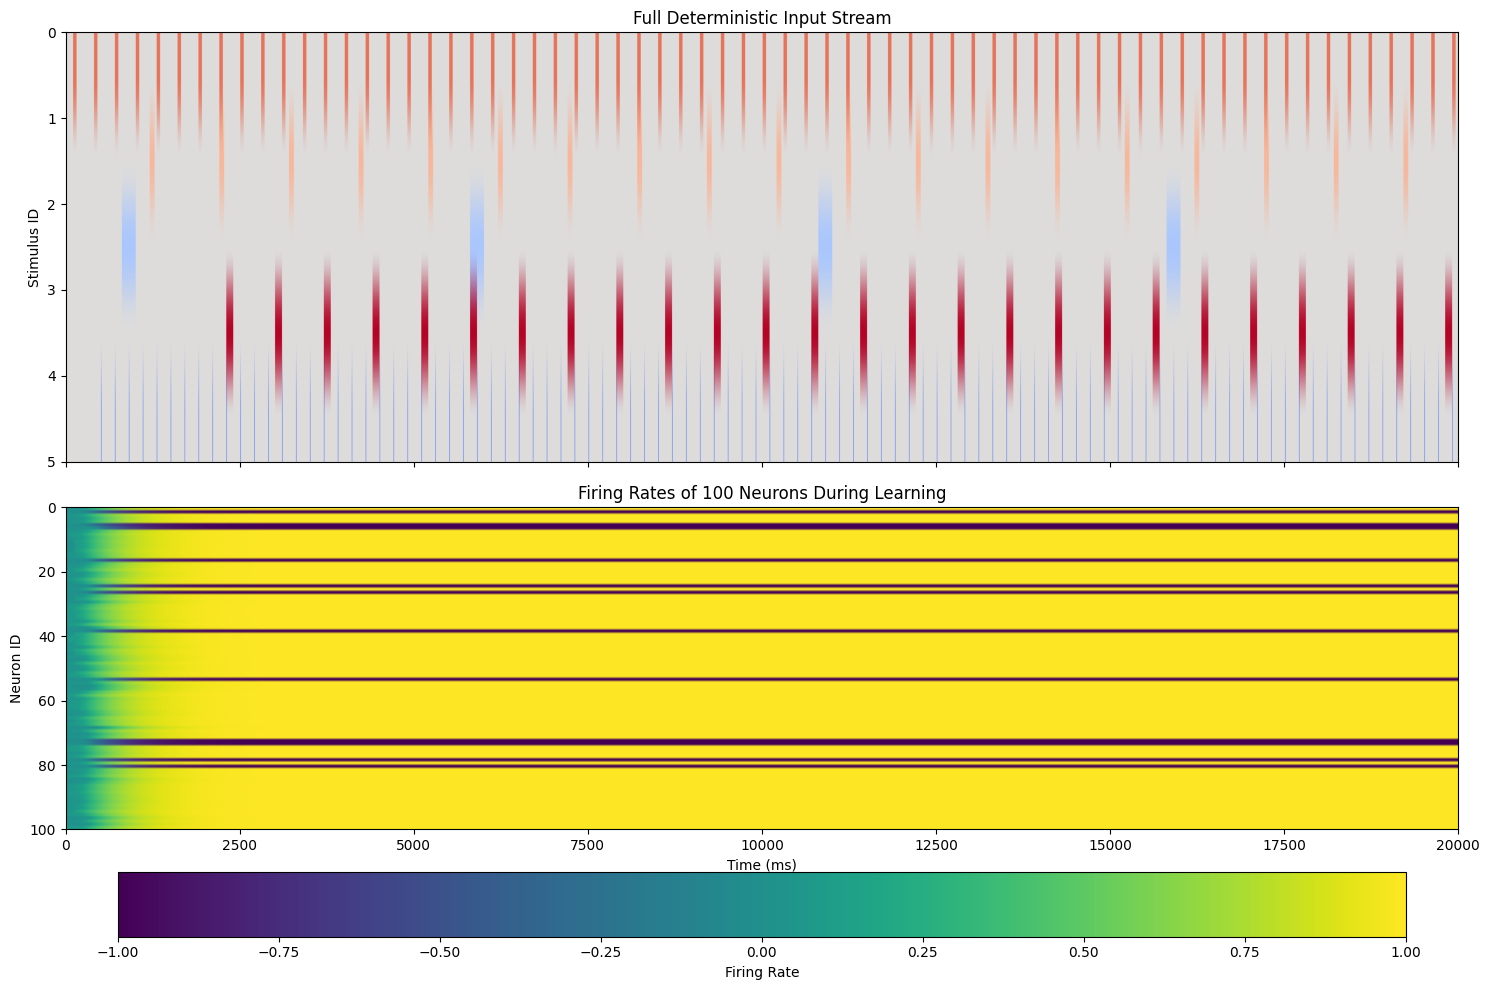

In [ ]:
fig, (ax0, ax1) = plt.subplots(2, 1, figsize=(15, 10), sharex=True)

# Plot the full input stream
ax0.imshow(input_stream, aspect='auto', extent=[0, simulation_time, model['nIn'], 0], cmap='coolwarm', vmin=-3, vmax=3)
ax0.set_title("Full Deterministic Input Stream")
ax0.set_ylabel("Stimulus ID")

# Plot the firing rates heatmap
im1 = ax1.imshow(firing_rates, aspect='auto', extent=[0, simulation_time, model['N'], 0])
ax1.set_title(f"Firing Rates of {model['N']} Neurons During Learning")
ax1.set_xlabel("Time (ms)")
ax1.set_ylabel("Neuron ID")
fig.colorbar(im1, ax=ax1, label="Firing Rate", orientation='horizontal', pad=0.1)

plt.tight_layout()
plt.show()


Running comprehensive recall test on the learned network...


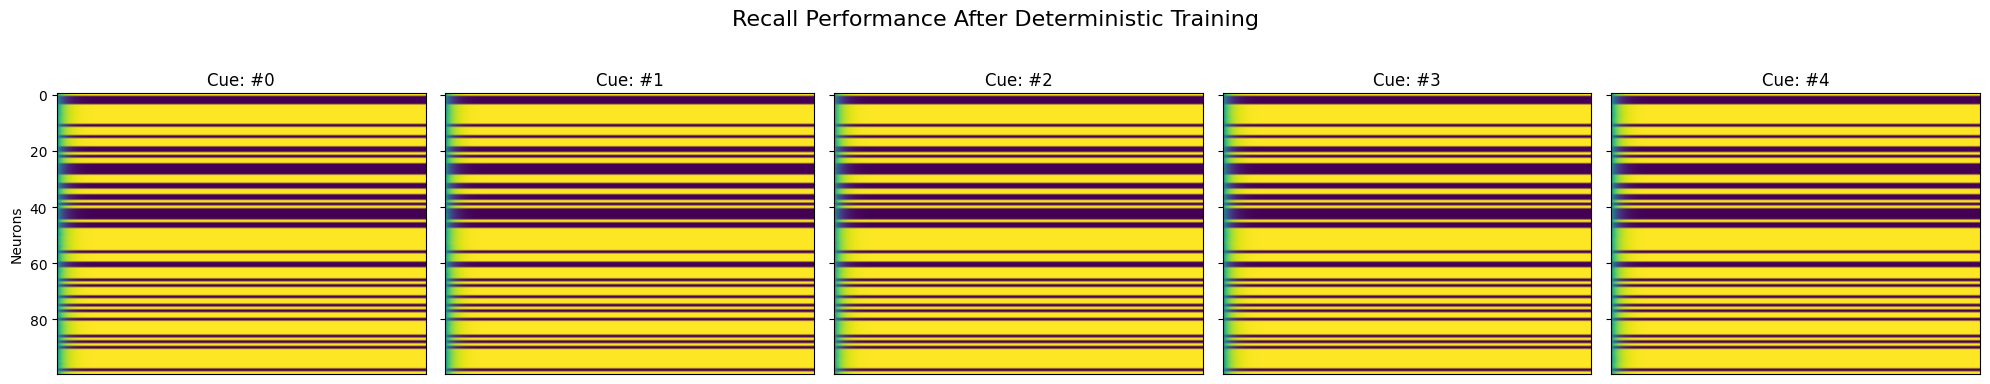

In [ ]:
def run_recall_test(J_matrix, stim_id_to_test):
    test_time = 1000.0
    n_test_timesteps = int(test_time / model['dt'])

    weak_cue_stream = np.zeros((model['nIn'], n_test_timesteps))
    cue_start_idx = int(100 / model['dt'])
    cue_end_idx = int(120 / model['dt'])
    weak_cue_stream[stim_id_to_test, cue_start_idx:cue_end_idx] = 0.2

    rates = np.zeros((model['N'], n_test_timesteps))
    rates[:, 0] = np.random.uniform(0, 0.1, size=(model['N']))
    for t in range(n_test_timesteps - 1):
        r_current = rates[:, t]
        I_synaptic = J_matrix @ r_current
        I_input = Jin @ weak_cue_stream[:, t]
        total_input = I_synaptic + I_input
        r_new = r_current + (model['dt'] / model['tau']) * (-r_current + model['nonlin'](total_input))
        rates[:, t+1] = np.clip(r_new, -1.0, 1.0)
    return rates

print("\nRunning comprehensive recall test on the learned network...")

# Create a grid of subplots for visualization
fig, axes = plt.subplots(1, model['nIn'], figsize=(20, 4), sharey=True)
fig.suptitle("Recall Performance After Deterministic Training", fontsize=16)

for stim_id in range(model['nIn']):
    ax = axes[stim_id]
    recall_rates = run_recall_test(J_learned, stim_id)

    im = ax.imshow(recall_rates, aspect='auto', vmin=-1, vmax=1, cmap='viridis')
    ax.set_title(f"Cue: #{stim_id}")
    ax.set_xticks([])
    if stim_id == 0:
        ax.set_ylabel("Neurons")

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# NEW METHOD

In [ ]:
import numpy as np
import math
import matplotlib.pyplot as plt

In [ ]:
model = {}

model['n_clusters'] = 3        # Number of specific memory pools
model['N_per_cluster'] = 500    # Neurons per memory cluster
model['N_e_specific'] = model['n_clusters'] * model['N_per_cluster'] # Neurons in specific pools
model['N_e_nonspecific'] = 400 # Non-specific excitatory pool
model['N_e'] = model['N_e_specific'] + model['N_e_nonspecific'] # Total excitatory neurons
model['N_i'] = 600             # Neurons in the shared inhibitory pool
model['N'] = model['N_e'] + model['N_i'] # Total neurons

model['tau_e'] = 20.0
model['tau_i'] = 10.0
model['dt'] = 0.1
model['nonlin'] = lambda x: np.where(x > 0, np.tanh(x), 0)

model['w_plus'] = 2.0     # Strong self-excitation within a cluster
model['w_minus'] = 1.0    # Weaker excitation between clusters
model['w_ei'] = 1.0       # E -> I connection strength
model['w_ie'] = 1.0       # I -> E connection strength

model['lr_hebbian'] = 0.001
model['weight_decay'] = 0.0005

model['nIn'] = model['n_clusters']
model['gIn'] = 1.0        # Strength of the external input


In [ ]:
J = np.zeros((model['N'], model['N']))
N_e_spec = model['N_e_specific']
N_e_non = model['N_e_nonspecific']
N_e = model['N_e']
N_i = model['N_i']
N_per_cluster = model['N_per_cluster']

# --- Set connections based on the architecture ---
# E -> I connections (from both specific and non-specific E pools)
J[N_e:, :N_e] = model['w_ei'] / math.sqrt(N_e)
# I -> E connections (to both specific and non-specific E pools)
J[:N_e, N_e:] = -model['w_ie'] / math.sqrt(N_i)

# --- Initialize E -> E connections ---
# Specific to Specific (between and within clusters)
for i in range(model['n_clusters']):
    for j in range(model['n_clusters']):
        row_slice = slice(i * N_per_cluster, (i + 1) * N_per_cluster)
        col_slice = slice(j * N_per_cluster, (j + 1) * N_per_cluster)
        block = np.random.uniform(0, 1, size=(N_per_cluster, N_per_cluster))
        weight = model['w_plus'] if i == j else model['w_minus']
        J[row_slice, col_slice] = block * weight / math.sqrt(N_per_cluster)

# Connections involving the non-specific pool
# Non-specific -> Non-specific
J[N_e_spec:N_e, N_e_spec:N_e] = model['w_minus'] / math.sqrt(N_e_non)
# Specific -> Non-specific
J[N_e_spec:N_e, :N_e_spec] = model['w_minus'] / math.sqrt(N_e_spec)
# Non-specific -> Specific
J[:N_e_spec, N_e_spec:N_e] = model['w_minus'] / math.sqrt(N_e_non)

np.fill_diagonal(J, 0)
J_initial = J.copy()

# Input matrix maps each input ONLY to its specific cluster
Jin = np.zeros((model['N'], model['nIn']))
for i in range(model['n_clusters']):
    row_slice = slice(i * N_per_cluster, (i + 1) * N_per_cluster)
    Jin[row_slice, i] = model['gIn']

In [ ]:
simulation_time = 15000.0
n_timesteps = int(simulation_time / model['dt'])
n_repeats = 60

stimulus_schedule = []
for _ in range(n_repeats):
    stimulus_schedule.extend(np.random.permutation(model['nIn']))

input_stream = np.zeros((model['nIn'], n_timesteps))
current_time = 100.0
for stim_id in stimulus_schedule:
    start_idx = int(current_time / model['dt'])
    end_idx = int((current_time + 50.0) / model['dt'])
    if end_idx >= n_timesteps: break
    input_stream[stim_id, start_idx:end_idx] = 1.0
    current_time += 250.0

In [ ]:
firing_rates = np.zeros((model['N'], n_timesteps))
firing_rates[:, 0] = np.random.uniform(0, 0.1, size=(model['N']))

tau_vec = np.array([model['tau_e']] * N_e + [model['tau_i']] * N_i)

for t in range(n_timesteps - 1):
    r_current = firing_rates[:, t]
    I_synaptic = J @ r_current
    I_input = Jin @ input_stream[:, t]
    total_input = I_synaptic + I_input

    r_new = r_current + (model['dt'] / tau_vec) * (-r_current + model['nonlin'](total_input))
    firing_rates[:, t+1] = np.clip(r_new, 0, 1.0)

    # --- FOCUSED HEBBIAN LEARNING (within-cluster E->E only) ---
    for i in range(model['n_clusters']):
        cluster_slice = slice(i * N_per_cluster, (i + 1) * N_per_cluster)
        r_post = firing_rates[cluster_slice, t+1]
        r_pre = firing_rates[cluster_slice, t]

        hebbian_update = np.outer(r_post, r_pre)
        delta_J = model['lr_hebbian'] * hebbian_update - model['weight_decay'] * J[cluster_slice, cluster_slice]
        J[cluster_slice, cluster_slice] += delta_J

    J[:N_e, :N_e] = np.maximum(0, J[:N_e, :N_e])

J_learned = J.copy()

In [ ]:
def run_recall_test(J_matrix, stim_id_to_test):
    test_time = 1000.0
    n_test_timesteps = int(test_time / model['dt'])

    weak_cue_stream = np.zeros((model['nIn'], n_test_timesteps))
    cue_start_idx = int(100 / model['dt'])
    cue_end_idx = int(120 / model['dt'])
    weak_cue_stream[stim_id_to_test, cue_start_idx:cue_end_idx] = 0.5

    rates = np.zeros((model['N'], n_test_timesteps))
    rates[:, 0] = np.random.uniform(0, 0.1, size=(model['N']))
    tau_vec_test = np.array([model['tau_e']] * N_e + [model['tau_i']] * N_i)

    for t in range(n_test_timesteps - 1):
        r_current = rates[:, t]
        I_synaptic = J_matrix @ r_current
        I_input = Jin @ weak_cue_stream[:, t]
        total_input = I_synaptic + I_input
        r_new = r_current + (model['dt'] / tau_vec_test) * (-r_current + model['nonlin'](total_input))
        rates[:, t+1] = np.clip(r_new, 0, 1.0)
    return rates

print("\nRunning comprehensive recall test on the learned network...")
fig, axes = plt.subplots(1, model['nIn'], figsize=(20, 4), sharey=True)
fig.suptitle("Recall Performance: Average Population Firing Rates", fontsize=16)

for stim_id in range(model['nIn']):
    ax = axes[stim_id]
    recall_rates = run_recall_test(J_learned, stim_id)

    # Calculate average rates for each population
    timesteps_array = np.arange(recall_rates.shape[1]) * model['dt']

    # Plot average rate for the cued cluster
    cued_slice = slice(stim_id * N_per_cluster, (stim_id + 1) * N_per_cluster)
    ax.plot(timesteps_array, np.mean(recall_rates[cued_slice, :], axis=0), label=f'Cued Cluster #{stim_id}', lw=2)

    # Plot average rate for one non-cued cluster
    other_id = (stim_id + 1) % model['n_clusters']
    other_slice = slice(other_id * N_per_cluster, (other_id + 1) * N_per_cluster)
    ax.plot(timesteps_array, np.mean(recall_rates[other_slice, :], axis=0), label='Other Cluster', color='gray', alpha=0.7)

    # Plot non-specific and inhibitory pools
    ax.plot(timesteps_array, np.mean(recall_rates[N_e_spec:N_e, :], axis=0), label='Non-specific Pool', color='purple', alpha=0.7)
    ax.plot(timesteps_array, np.mean(recall_rates[N_e:, :], axis=0), label='Inhibitory Pool', color='red', alpha=0.7)

    ax.set_title(f"Cue: #{stim_id}")
    ax.set_xlabel("Time (ms)")
    if stim_id == 0:
        ax.set_ylabel("Avg. Firing Rate")
        ax.legend()
    ax.grid(True)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()